# Introduction
State notebook purpose here

### Imports
Import libraries and write settings here.

In [1]:
# Notebooks specific imports
from IPython import get_ipython
ipython = get_ipython()
#Expand notebook display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload
%autoreload 2

# Basic useful imports
import re
import time
import yaml
from pprint import pprint
from pathlib import Path
import h5py

# Data manipulation
import numpy as np
from scipy.special import erf
from scipy.integrate import quad
import scipy.stats as stats

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import (Circle, RegularPolygon, FancyArrowPatch, ArrowStyle)
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, NullFormatter)
import matplotlib.colors as colors

### Style settings

In [2]:
graph_sty = {
    "axes.titlesize": 20,
    "axes.labelsize": 24,
    "lines.linewidth": 3,
    "lines.markersize": 10,
    "xtick.labelsize": 24,
    "ytick.labelsize": 24,
    "font.size": 20,
    "font.sans-serif": 'Helvetica',
    "text.usetex": False,
    'mathtext.fontset': 'cm',
}
plt.style.use(graph_sty)
        

# Functions

In [3]:
# To read in data from AMSOS
class filament():

    def __init__(self, line):
        data = line.split()
        self.gid = data[1]
        dat = np.asarray(data[2:], dtype=np.double)
        self.radius = dat[0]
        self.minus_end = dat[1:4]
        self.plus_end = dat[4:7]

        self.vec = self.plus_end - self.minus_end
        self.lengthxy = np.linalg.norm(self.vec[:-1])
        self.length = np.linalg.norm(self.vec)
        self.orientation = self.vec / self.length

        self.theta = -np.arctan2(self.orientation[1], self.orientation[0])

    def get_com(self):
        return .5*(self.plus_end + self.minus_end)

def read_dat_sylinder(fpath):
    # Read a SylinderAscii_X.dat file

    # open the file and read the lines
    with fpath.open('r') as file1:
        filecontent = file1.readlines()

        # Delete the first two lines because they dont have any data
        filecontent[0:2] = []

        # Create list of filaments
        filaments = sorted([filament(line)
                            for line in filecontent], key=lambda x: int(x.gid))
    return filaments

# Test graphs

In [4]:
data_path = Path("21-03-31_AMchr1_hilbert4096_confine_nt3600/")

## Proximity

In [49]:
def gauss_weighted_contact(sep_mat, sigma=.020):
    return np.exp(-np.power(sep_mat,2)/(2.*(sigma*sigma)))

def log_gauss_weighted_contact(sep_mat, sigma=.020):
    return -np.power(sep_mat,2)/(2.*(sigma*sigma))/np.log(10)


In [7]:
#test_com_arr = np.asarray([[0,0,0],[1,0,0],[2,0,0],[5,0,0],[0,0,1]])
#test_sep_mat = make_separation_mat(test_com_arr)
#print(test_sep_mat)

## Energy

In [8]:
def get_energy_arrays(h5_data, write=False):
    """TODO: Docstring for get_mean_energy_array.

    @param h5_data HDF5 data file to analyze with all raw data about filaments
    @param write If true, will write data directly to the analysis group in
                 the h5_data file.
    @return: TODO

    """
    sy_dat = h5_data['raw_data']['sylinders'][...]
    params = yaml.safe_load(h5_data.attrs['RunConfig'])
    k_spring = params['linkKappa']
    kbt = params['KBT']
    rest_length = params['linkGap'] + sy_dat[1:, 1, :] + sy_dat[:-1, 1, :]
    sep_vec = sy_dat[1:, 2:5, :] - sy_dat[:-1, 5:8, :]

    sep_mag = np.linalg.norm(sep_vec, axis=1)

    energy_arr = .5 * k_spring * np.power(sep_mag - rest_length, 2)
    mean_energy = np.mean(energy_arr, axis=0)
    sem_energy = stats.sem(energy_arr, axis=0)
    expt_energy = kbt * (.5 - 1./(1. + (k_spring*rest_length[0,0]*rest_length[0,0]/kbt)))
    if write:
        energy_dset = h5_data['analysis'].create_dataset(
            'energy', data=np.stack(mean_energy, std_energy))
        energy_dset.attrs['nsylinders'] = energy_arr.shape[0]
    return mean_energy, sem_energy, expt_energy


0.0006565992
0.0020436892541110963


Text(0, 0.5, 'Mean spring energy (pN$\\cdot \\mu$m)')

Text(0.5, 0, 'Time (sec)')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


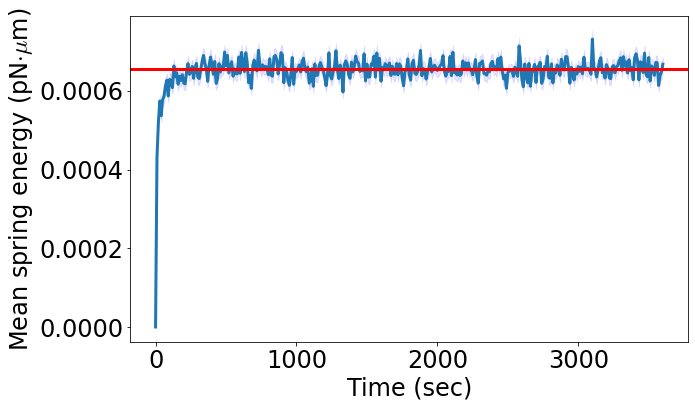

In [9]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
with h5py.File(next(data_path.glob('*.h5')), 'r+') as h5_data:

    mean_energy, sem_energy, expt_energy = get_energy_arrays(h5_data)
    time = h5_data['time'][...]

    # print(sy_dat)
    #end_end_sep = np.linalg.norm(sy_dat[-1,5:8,:] - sy_dat[0,5:8,:],axis=0)
    # print(end_end_sep)
    ax.plot(time, mean_energy, label="Self-avoidng")
    ax.fill_between(time, (mean_energy-sem_energy), (mean_energy+sem_energy), color='blue', alpha=0.1)
    
    energy_mean = mean_energy[int(mean_energy.size * .75):].mean()
    print(energy_mean)
    print(expt_energy)
    
    
    ax.axhline(energy_mean, color='r')
    ax.set_ylabel(r"Mean spring energy (pN$\cdot \mu$m)")
    ax.set_xlabel("Time (sec)")


## Overlap

In [13]:
def get_sep_hist(h5_data, nbins=100, ss_ind=0, write=False):
    """Returns a 2D histogram of bead separations vs time

    @param h5_data TODO
    @return: TODO

    """
    params = yaml.safe_load(h5_data.attrs['RunConfig'])
    hist_min = params['sylinderDiameter'] * .8
    hist_max = params['sylinderDiameter'] * 1.2

    dist_hist = []
    dist_mat = get_sep_dist_mat(h5_data, ss_ind)

    for i in range(dist_mat.shape[-1]):
        hist, bin_edges = np.histogram(
            dist_mat[:, :, i].flatten(), nbins, range=(hist_min, hist_max))
        dist_hist += [hist * .5]

    return dist_hist, bin_edges


def get_sep_dist_mat(h5_data, ss_ind=0, write=False):
    """Returns a NxNxM matrix of NXN filaments distances over M time points
    starting at ss_ind time point.

    @param h5_data TODO
    @return: TODO

    """
    sy_dat = h5_data['raw_data']['sylinders'][...]

    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])

    dist_mat = np.linalg.norm((com_arr[:, np.newaxis, :, ss_ind:] -
                               com_arr[np.newaxis, :, :, ss_ind:]),
                              axis=2)

    return dist_mat


def get_overlap_arrs(dist_mat, sy_diam):
    """Returns a NxNxM matrix of NXN filaments distances over M time points
    starting at ss_ind time point.

    @param h5_data TODO
    @return: TODO

    """
    is_overlap_mat = (dist_mat < sy_diam).astype(int)
    num_overlap = .5 * (is_overlap_mat.sum(axis=(0, 1))
                        - dist_mat.shape[0])  # remove self-overlap
    overlap_dist_mat = np.einsum('ijk, ijk -> ijk', dist_mat, is_overlap_mat)
    avg_overlap_arr = (.5*overlap_dist_mat.sum(axis=(0, 1))) / num_overlap
    min_overlap_arr = np.ma.masked_values(overlap_dist_mat, 0).min(axis=(0, 1))

    return num_overlap, avg_overlap_arr, min_overlap_arr




Text(0.5, 0, 'Bead COM separation ($\\mu$m)')

Text(0, 0.5, 'Time (sec)')

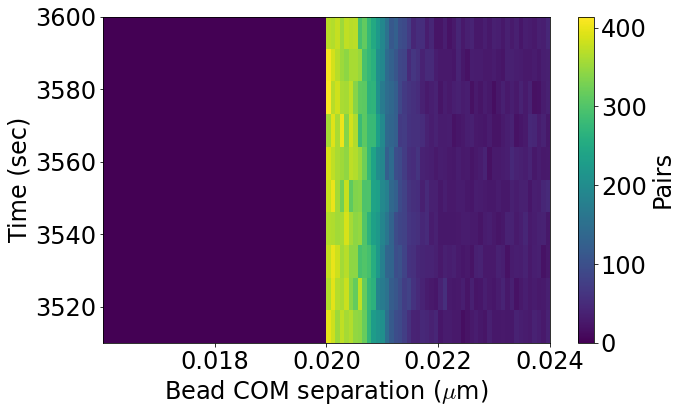

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
with h5py.File(next(data_path.glob('*.h5')), 'r+') as h5_data:
    diff_hist, bin_edges = get_sep_hist(h5_data, ss_ind=-10)
    time = h5_data['time'][...]

    c = ax.pcolorfast(bin_edges, time[-10:], diff_hist)
    fig.colorbar(c, ax=ax, label=r'Pairs')
    ax.set_xlabel(r"Bead COM separation ($\mu$m)")
    ax.set_ylabel("Time (sec)")


<ipython-input-13-5b56937083a3>:54: RuntimeWarning: invalid value encountered in true_divide
  avg_overlap_arr = (.5*overlap_dist_mat.sum(axis=(0, 1))) / num_overlap


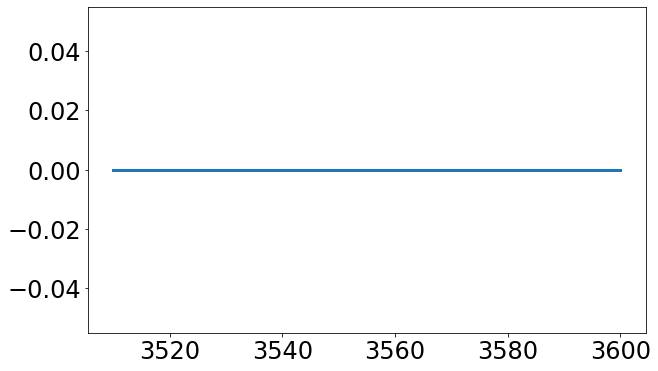

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
with h5py.File(next(data_path.glob('*.h5')), 'r+') as h5_data:
    dist_mat = get_sep_dist_mat(h5_data, -10)
    time_arr = h5_data['time'][...]
    params = yaml.safe_load(h5_data.attrs['RunConfig'])
    sy_diam = params['sylinderDiameter']
    
    overlap_arr,_,_ = get_overlap_arrs(dist_mat, sy_diam)
    ax.plot(time_arr[-10:], overlap_arr)
    
    

In [17]:
data_path_h2 = Path("21-03-31_AMchr1_scan5_hilbert4096_confine_dt.01-20/simulations/dt2")
ss_ind = -100
with h5py.File(next(data_path_h2.glob('*.h5')), 'r+') as h5_data:
    dist_mat_h2 = get_sep_dist_mat(h5_data, ss_ind)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


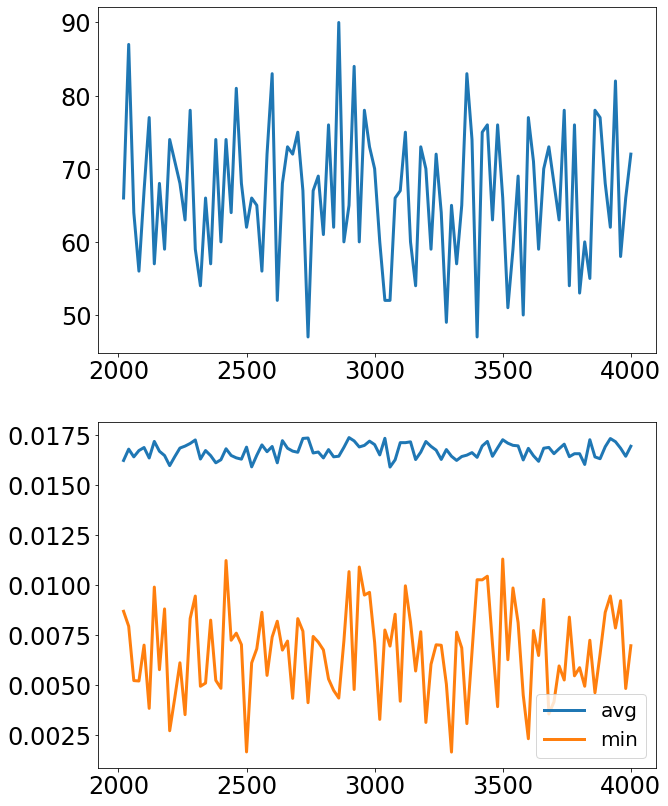

In [18]:
fig, ax = plt.subplots(2, 1, figsize=(10, 14))
#data_path_h1 = Path("21-03-31_AMchr1_scan5_hilbert4096_confine_dt.01-20/simulations/dt2")

with h5py.File(next(data_path_h2.glob('*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][...]
    params = yaml.safe_load(h5_data.attrs['RunConfig'])
    sy_diam = params['sylinderDiameter']
    
    overlap_arr, avg_overlap_arr, min_overlap_arr = get_overlap_arrs(dist_mat_h2, sy_diam)
    ax[0].plot(time_arr[ss_ind:], overlap_arr)
    ax[1].plot(time_arr[ss_ind:], avg_overlap_arr,label='avg')
    ax[1].plot(time_arr[ss_ind:], min_overlap_arr, label='min')
    ax[1].legend()
    

In [19]:
data_path_h1 = Path("21-03-31_AMchr1_scan5_hilbert4096_confine_dt.01-20/simulations/dt1")
ss_ind = -100
with h5py.File(next(data_path_h1.glob('*.h5')), 'r+') as h5_data:
    dist_mat_h1 = get_sep_dist_mat(h5_data, ss_ind)

mean avg_overlap: 0.0025655577982618243, $\pm$ 6.24542054481697e-05


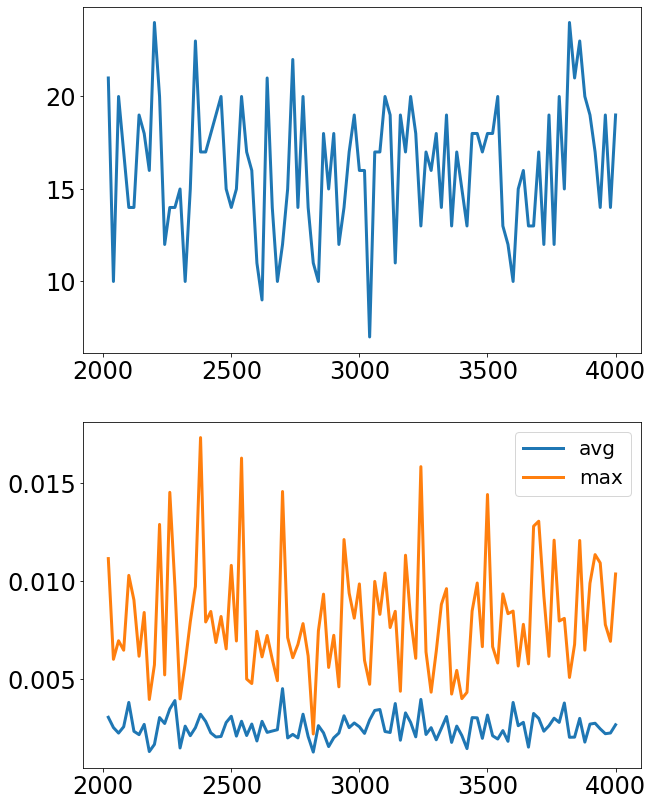

In [20]:
fig, ax = plt.subplots(2, 1, figsize=(10, 14))
#data_path_h1 = Path("21-03-31_AMchr1_scan5_hilbert4096_confine_dt.01-20/simulations/dt2")

with h5py.File(next(data_path_h1.glob('*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][...]
    params = yaml.safe_load(h5_data.attrs['RunConfig'])
    sy_diam = params['sylinderDiameter']
    
    overlap_arr, avg_overlap_arr, min_overlap_arr = get_overlap_arrs(dist_mat_h1, sy_diam)
    ax[0].plot(time_arr[ss_ind:], overlap_arr)
    ax[1].plot(time_arr[ss_ind:], sy_diam - avg_overlap_arr,label='avg')
    ax[1].plot(time_arr[ss_ind:], sy_diam - min_overlap_arr, label='max')
    ax[1].legend()
    print(f'mean avg_overlap: {sy_diam - avg_overlap_arr.mean()}, $\pm$ {stats.sem(avg_overlap_arr)}')
    

In [21]:
data_path_h_5 = Path("21-03-31_AMchr1_scan5_hilbert4096_confine_dt.01-20/simulations/dt0.5")
ss_ind = -100
with h5py.File(next(data_path_h_5.glob('*.h5')), 'r+') as h5_data:
    dist_mat_h_5 = get_sep_dist_mat(h5_data, ss_ind)

<ipython-input-13-5b56937083a3>:54: RuntimeWarning: invalid value encountered in true_divide
  avg_overlap_arr = (.5*overlap_dist_mat.sum(axis=(0, 1))) / num_overlap


mean avg_overlap: 0.0020994680584681923, $\pm$ 1.407052941362897e+18


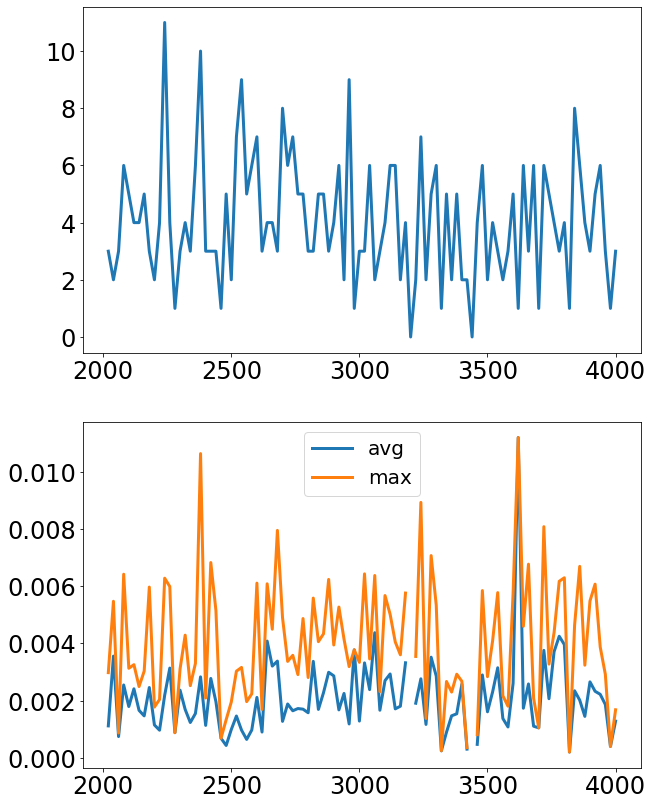

In [22]:
fig, ax = plt.subplots(2, 1, figsize=(10, 14))
#data_path_h1 = Path("21-03-31_AMchr1_scan5_hilbert4096_confine_dt.01-20/simulations/dt2")

with h5py.File(next(data_path_h_5.glob('*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][...]
    params = yaml.safe_load(h5_data.attrs['RunConfig'])
    sy_diam = params['sylinderDiameter']
    
    overlap_arr, avg_overlap_arr, min_overlap_arr = get_overlap_arrs(dist_mat_h_5, sy_diam)
    ax[0].plot(time_arr[ss_ind:], overlap_arr)
    ax[1].plot(time_arr[ss_ind:], sy_diam - avg_overlap_arr,label='avg')
    ax[1].plot(time_arr[ss_ind:], sy_diam - min_overlap_arr, label='max')
    ax[1].legend()
    print(f"mean avg_overlap: {np.ma.fix_invalid(sy_diam - avg_overlap_arr,fill_value=0).mean()}, $\pm$ {stats.sem(np.ma.fix_invalid(avg_overlap_arr,np.nan))}")
    

In [23]:
print(f"mean avg_overlap: {np.ma.fix_invalid(sy_diam - avg_overlap_arr,fill_value=0).mean()}, $\pm$ {stats.sem(np.ma.fix_invalid(avg_overlap_arr,fill_value=0))}")

mean avg_overlap: 0.0020994680584681923, $\pm$ 0.00028540455929171863


In [24]:
data_path_h_2 = Path("21-03-31_AMchr1_scan5_hilbert4096_confine_dt.01-20/simulations/dt0.2")
ss_ind = -100
with h5py.File(next(data_path_h_2.glob('*.h5')), 'r+') as h5_data:
    dist_mat_h_2 = get_sep_dist_mat(h5_data, ss_ind)

<ipython-input-13-5b56937083a3>:54: RuntimeWarning: invalid value encountered in true_divide
  avg_overlap_arr = (.5*overlap_dist_mat.sum(axis=(0, 1))) / num_overlap


mean avg_overlap: 0.0009107800538185988, $\pm$ 0.0008958609435872356


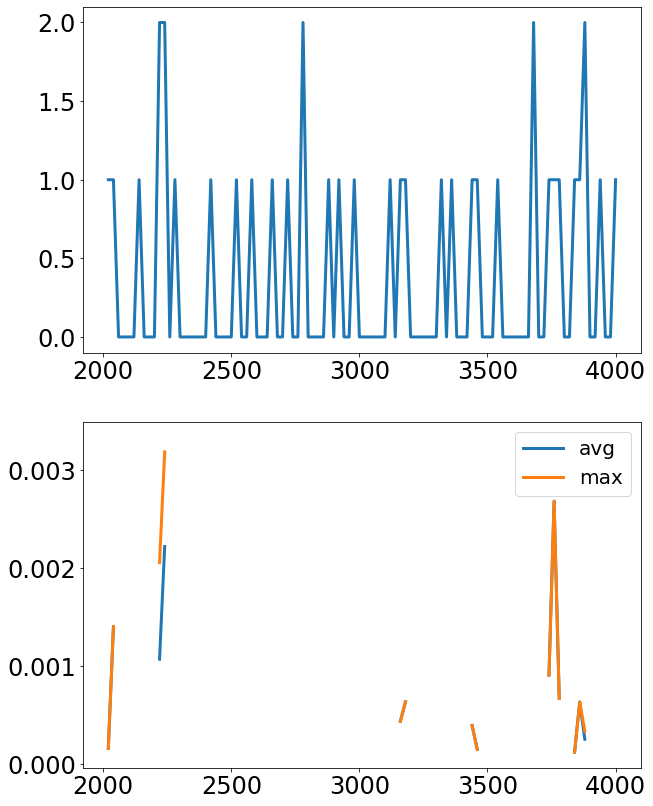

In [25]:
fig, ax = plt.subplots(2, 1, figsize=(10, 14))
#data_path_h1 = Path("21-03-31_AMchr1_scan5_hilbert4096_confine_dt.01-20/simulations/dt2")

with h5py.File(next(data_path_h_2.glob('*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][...]
    params = yaml.safe_load(h5_data.attrs['RunConfig'])
    sy_diam = params['sylinderDiameter']
    
    overlap_arr, avg_overlap_arr, min_overlap_arr = get_overlap_arrs(dist_mat_h_2, sy_diam)
    ax[0].plot(time_arr[ss_ind:], overlap_arr)
    ax[1].plot(time_arr[ss_ind:], sy_diam - avg_overlap_arr,label='avg')
    ax[1].plot(time_arr[ss_ind:], sy_diam - min_overlap_arr, label='max')
    ax[1].legend()
    print(f"mean avg_overlap: {np.ma.fix_invalid(sy_diam - avg_overlap_arr,fill_value=0).mean()}, $\pm$ {stats.sem(np.ma.fix_invalid(avg_overlap_arr,fill_value=0))}")
    

## Rouse modes

In [26]:
def get_rouse_modes_at_t(pos_arr, nmodes=20):
    """TODO: Docstring for get_rouse_modes.

    @param sphere_dat TODO
    @param nmodes TODO
    @return: TODO

    """
    modes = []
    mode_0 = pos_arr[0]
    nbeads = pos_arr.shape[0]

    for k in range(nmodes):
        modes += [np.zeros(3)]
        for n in range(nbeads - 1):
            modes[-1] += ((pos_arr[n] - mode_0) *
                          np.cos(np.pi*(n + .5) * k / nbeads))

    return np.asarray(modes) / (nbeads)

def get_rouse_modes(pos_mat, nmodes=20):
    """TODO: Docstring for get_rouse_modes.

    @param sphere_dat TODO
    @param nmodes TODO
    @return: TODO

    """
    nsteps = pos_mat.shape[-1]
    mode_arr = np.zeros((nmodes, 3, nsteps))
    for i in range(nsteps):
        mode_arr[:, :, i] = get_rouse_modes_at_t(pos_mat[:, :, i], nmodes)

    return mode_arr

def get_rouse_mode_corr(mode_mat):
    """TODO: Docstring for get_rouse_modes.

    @param mode_mat TODO
    @return: TODO

    """
    nsteps = mode_mat.shape[-1]
    nmodes = mode_mat.shape[0]
    mode_corr = np.zeros((nmodes, nsteps))
    print(mode_corr.shape)

    for t in range(nsteps):
        for j in range(nsteps - t):
            mode_corr[:, t] += np.einsum('ij,ij->i',mode_mat[:, :, t + j],
                                      mode_mat[:, :, j])
        mode_corr[:, t] /= (nsteps - t)

    return mode_corr



In [27]:
data_path_line = Path("21-03-11_AMchr1_NS_line/")
with h5py.File(next(data_path_line.glob('*.h5')), 'r+') as h5_data:
    time_arr = h5_data['time'][...]
    sy_dat = h5_data['raw_data']['sylinders'][...]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
    mode_mat = get_rouse_modes(com_arr)
    
    

(20, 3, 362)
(20, 362)


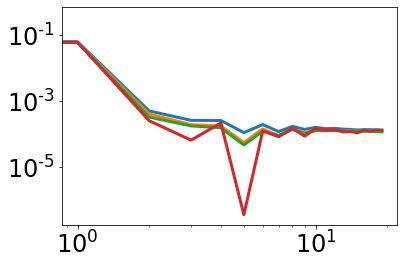

In [28]:
print(mode_mat.shape)
mode_corr = get_rouse_mode_corr(mode_mat)
#plt.ylog(mode_corr[0]/mode_corr[0,0])
# plt.loglog(mode_corr[1]/mode_corr[1,0])
# plt.loglog(mode_corr[2]/mode_corr[2,0])
plt.loglog(mode_corr[:,0])
plt.loglog(mode_corr[:,50])
plt.loglog(mode_corr[:,100])
plt.loglog(mode_corr[:,300])

## Radial distribution from pin

In [186]:
def distr_hists(pos_mat, free_frac_chain=.5, rel_ind=0, nbins=100, hist_max=1):
    """TODO: Docstring for radial_distr.
    @param pos_mat TODO
    @param free_frac_chain TODO
    @param rel_ind TODO
    @param nbins TODO
    @return: TODO
    """
    nbeads = pos_mat.shape[0]
    ind = int(nbeads * free_frac_chain)


    rel_vec_arr = pos_mat[ind, :, :] - pos_mat[rel_ind, :, :]
    dist_arr = np.linalg.norm(rel_vec_arr, axis=0)

    dist_hist, dist_bin_edges = np.histogram(dist_arr, nbins, range=[0, hist_max], density=True)
    z_rho_hist, rho_bin_edges, z_bin_edges = np.histogram2d(
        np.linalg.norm(rel_vec_arr[:-1, :], axis=0), rel_vec_arr[-1, :], 
        int(nbins/2), range=[[0, hist_max], [-hist_max, hist_max]], density=True)

    return ((dist_hist, dist_bin_edges),
            (z_rho_hist, rho_bin_edges, z_bin_edges))

def total_distr_hists(pos_mat, rel_ind=0, nbins=100, hist_max=1):
    """TODO: Docstring for radial_distr.
    @param pos_mat TODO
    @param free_frac_chain TODO
    @param rel_ind TODO
    @param nbins TODO
    @return: TODO
    """
    rel_vec_arr = pos_mat - (pos_mat[rel_ind])[np.newaxis,:,:]
    dist_arr = np.linalg.norm(rel_vec_arr, axis=1).flatten()

    dist_hist, dist_bin_edges = np.histogram(dist_arr, nbins, range=[0, hist_max], density=True)
    z_rho_hist, rho_bin_edges, z_bin_edges = np.histogram2d(
        np.linalg.norm(rel_vec_arr[:,:-1, :], axis=1).flatten(), 
        rel_vec_arr[:,-1, :].flatten(), int(nbins/2), 
        range=[[0, hist_max], [-hist_max, hist_max]], density=True)

    return ((dist_hist, dist_bin_edges),
            (z_rho_hist, rho_bin_edges, z_bin_edges))

def get_all_rog_stats(pos_mat, rel_ind=0):
    rel_vec_arr = pos_mat - (pos_mat[rel_ind])[np.newaxis,:,:]
    pos_avg_arr = rel_vec_arr.mean(axis=2)
    pos_std_arr = rel_vec_arr.std(axis=2)
    rad_pos_arr = np.linalg.norm(pos_avg_arr, axis = 1)
    rog_arr = np.linalg.norm(pos_std_arr, axis = 1)
    
    return(pos_avg_arr, pos_std_arr, rad_pos_arr, rog_arr)

def get_time_avg_contact_mat(com_arr, sigma = .02, avg_block_step = 1):
    #np.convolve(com_arr[:,0,:].flatten(), np.ones(avg_block_steps), 'valid') / avg_block_step
    #np.convolve(com_arr[:,0,:].flatten(), np.ones(avg_block_steps), 'valid') / avg_block_step
    #np.convolve(com_arr[:,0,:].flatten(), np.ones(avg_block_steps), 'valid') / avg_block_step
    #mov_avg_com_arr = 
    reduc_com_arr = com_arr[::avg_block_step,:,:] # simple downsampling
    sep_mat = np.linalg.norm(reduc_com_arr[:,np.newaxis,:,:] - reduc_com_arr[np.newaxis,:,:,:], axis=2)
    log_contact_map = log_gauss_weighted_contact(sep_mat, sigma)
    return log_contact_map.mean(axis=-1)
    
    
    

In [102]:
def make_total_distr_plots(com_arr, log_contact_avg=None, hist_max=1., rel_ind=0, vmin=-50):
    fig, axarr = plt.subplots(2,3, figsize=(26,16))
    ax = axarr.flatten()
    ax[1].set_aspect('equal')
    dist_hist_dat, z_rho_hist_dat = total_distr_hists(com_arr, hist_max=hist_max, rel_ind=rel_ind)
    ax[0].bar(dist_hist_dat[1][:-1], dist_hist_dat[0], width=np.diff(dist_hist_dat[1]), align='edge')
    
    X, Y = np.meshgrid(z_rho_hist_dat[1], z_rho_hist_dat[2])
    ax[1].pcolorfast(X, Y, z_rho_hist_dat[0].T)
    pos_avg_arr, pos_std_arr, rad_pos_arr, rog_arr = get_all_rog_stats(com_arr, rel_ind=rel_ind)
    ax[2].scatter(np.arange(rog_arr.size), rad_pos_arr)
    ax[3].scatter(np.arange(rog_arr.size), rog_arr)
    
    if isinstance(log_contact_avg, np.ndarray):
        nbeads = com_arr.shape[0]
        x = np.arange(nbeads+1)[::int((nbeads)/log_contact_avg.shape[0])]
        X,Y = np.meshgrid(x,x)
        c = ax[4].pcolorfast(X,Y,log_contact_avg, vmin=-50)
        fig.colorbar(c,label="Log contact probability")
        
    
    ax[0].set_xlabel(r'$|{\bf r} - {\bf r}_0|$ ($\mu$m)')
    ax[0].set_ylabel(r'Probability density ($\mu$m$^{-1}$)')
    ax[1].set_xlabel(r'$\rho - \rho_0$ ($\mu$m)')
    ax[1].set_ylabel(r'$z-z_0$ ($\mu$m)')
    ax[2].set_xlabel(r'Bead index')
    ax[2].set_ylabel(r'$|{\bf r} - {\bf r}_0|$ ($\mu$m)')
    ax[3].set_xlabel(r'Bead index')
    ax[3].set_ylabel(r'$\sigma_{|{\bf r} - {\bf r}_0|}$ ($\mu$m)')
    plt.tight_layout()
    
        
    return fig, ax
    

### Saw seed 0

<BarContainer object of 100 artists>

Text(0.5, 0, '$|{\\bf r} - {\\bf r}_0|$ ($\\mu$m)')

Text(0, 0.5, 'Probability density ($\\mu$m$^{-1}$)')

Text(0.5, 0, '$|{\\bf \\rho} - {\\bf \\rho}_0|$ ($\\mu$m)')

Text(0, 0.5, '$z-z_0$ ($\\mu$m)')

0.069804005


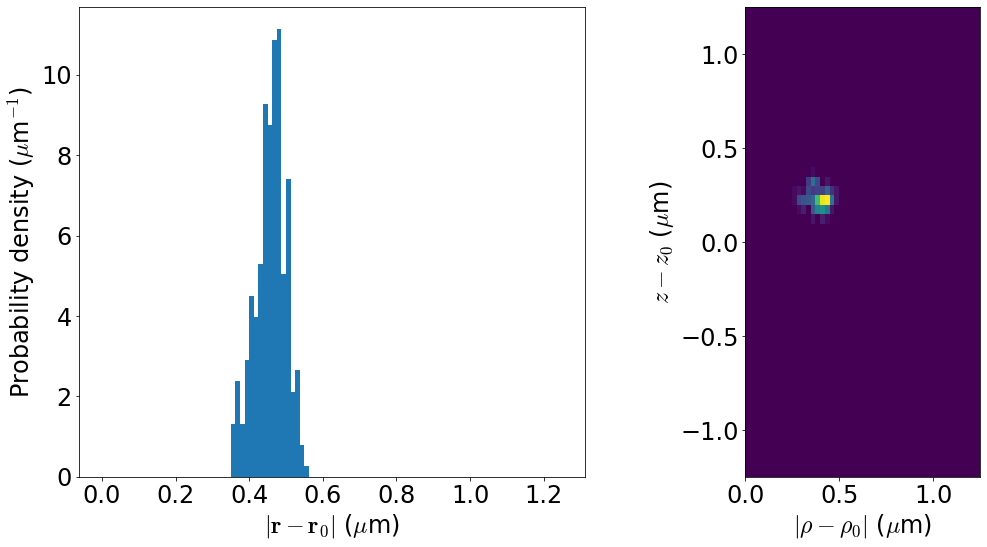

In [89]:
data_path_pin0 = Path("21-04-05_AMchr1_loop4128eq_pin_scan.5/simulations/s0/")
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[1].set_aspect('equal')
with h5py.File(next(data_path_pin0.glob('*.h5')), 'r+') as h5_data:
    sy_dat = h5_data['raw_data']['sylinders'][...]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
    dist_hist_dat, z_rho_hist_dat = distr_hists(com_arr, .5, hist_max=1.25)
    ax[0].bar(dist_hist_dat[1][:-1], dist_hist_dat[0],
              width=np.diff(dist_hist_dat[1]), align='edge')

    X, Y = np.meshgrid(z_rho_hist_dat[1], z_rho_hist_dat[2])
    ax[1].pcolormesh(X, Y, z_rho_hist_dat[0].T)

    ax[0].set_xlabel(r'$|{\bf r} - {\bf r}_0|$ ($\mu$m)')
    ax[0].set_ylabel(r'Probability density ($\mu$m$^{-1}$)')
    ax[1].set_xlabel(r'$|{\bf \rho} - {\bf \rho}_0|$ ($\mu$m)')
    ax[1].set_ylabel(r'$z-z_0$ ($\mu$m)')

    plt.tight_layout()
    print(get_all_rog_stats(com_arr)[-1][int(com_arr.shape[0]*.5)])

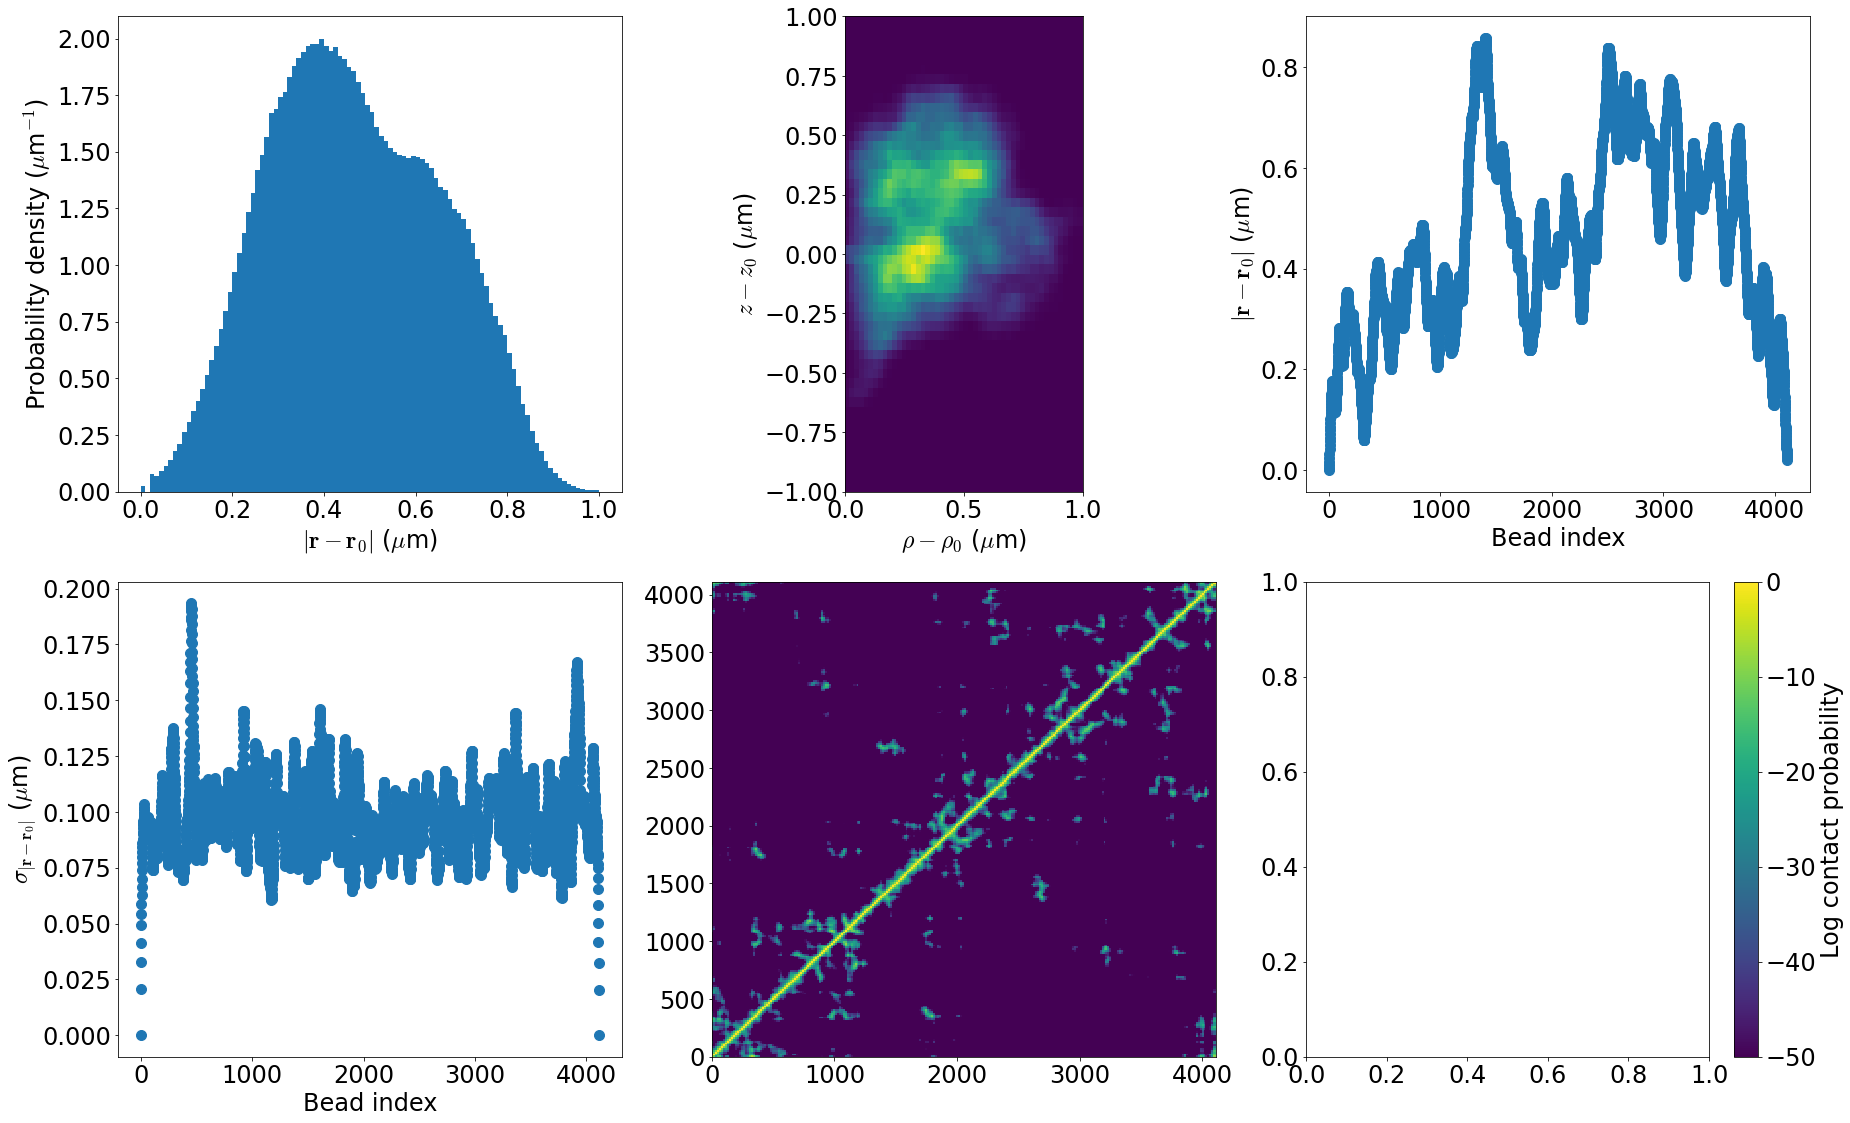

In [90]:
data_path_pin0 = Path("21-04-05_AMchr1_loop4128eq_pin_scan.5/simulations/s0/")
with h5py.File(next(data_path_pin0.glob('*.h5')), 'r+') as h5_data:
    sy_dat = h5_data['raw_data']['sylinders'][...]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
    log_contact_avg_mat = get_time_avg_contact_mat(com_arr, avg_block_step = 16)
    fig, ax = make_total_distr_plots(com_arr, log_contact_avg_mat, hist_max=1.)
    

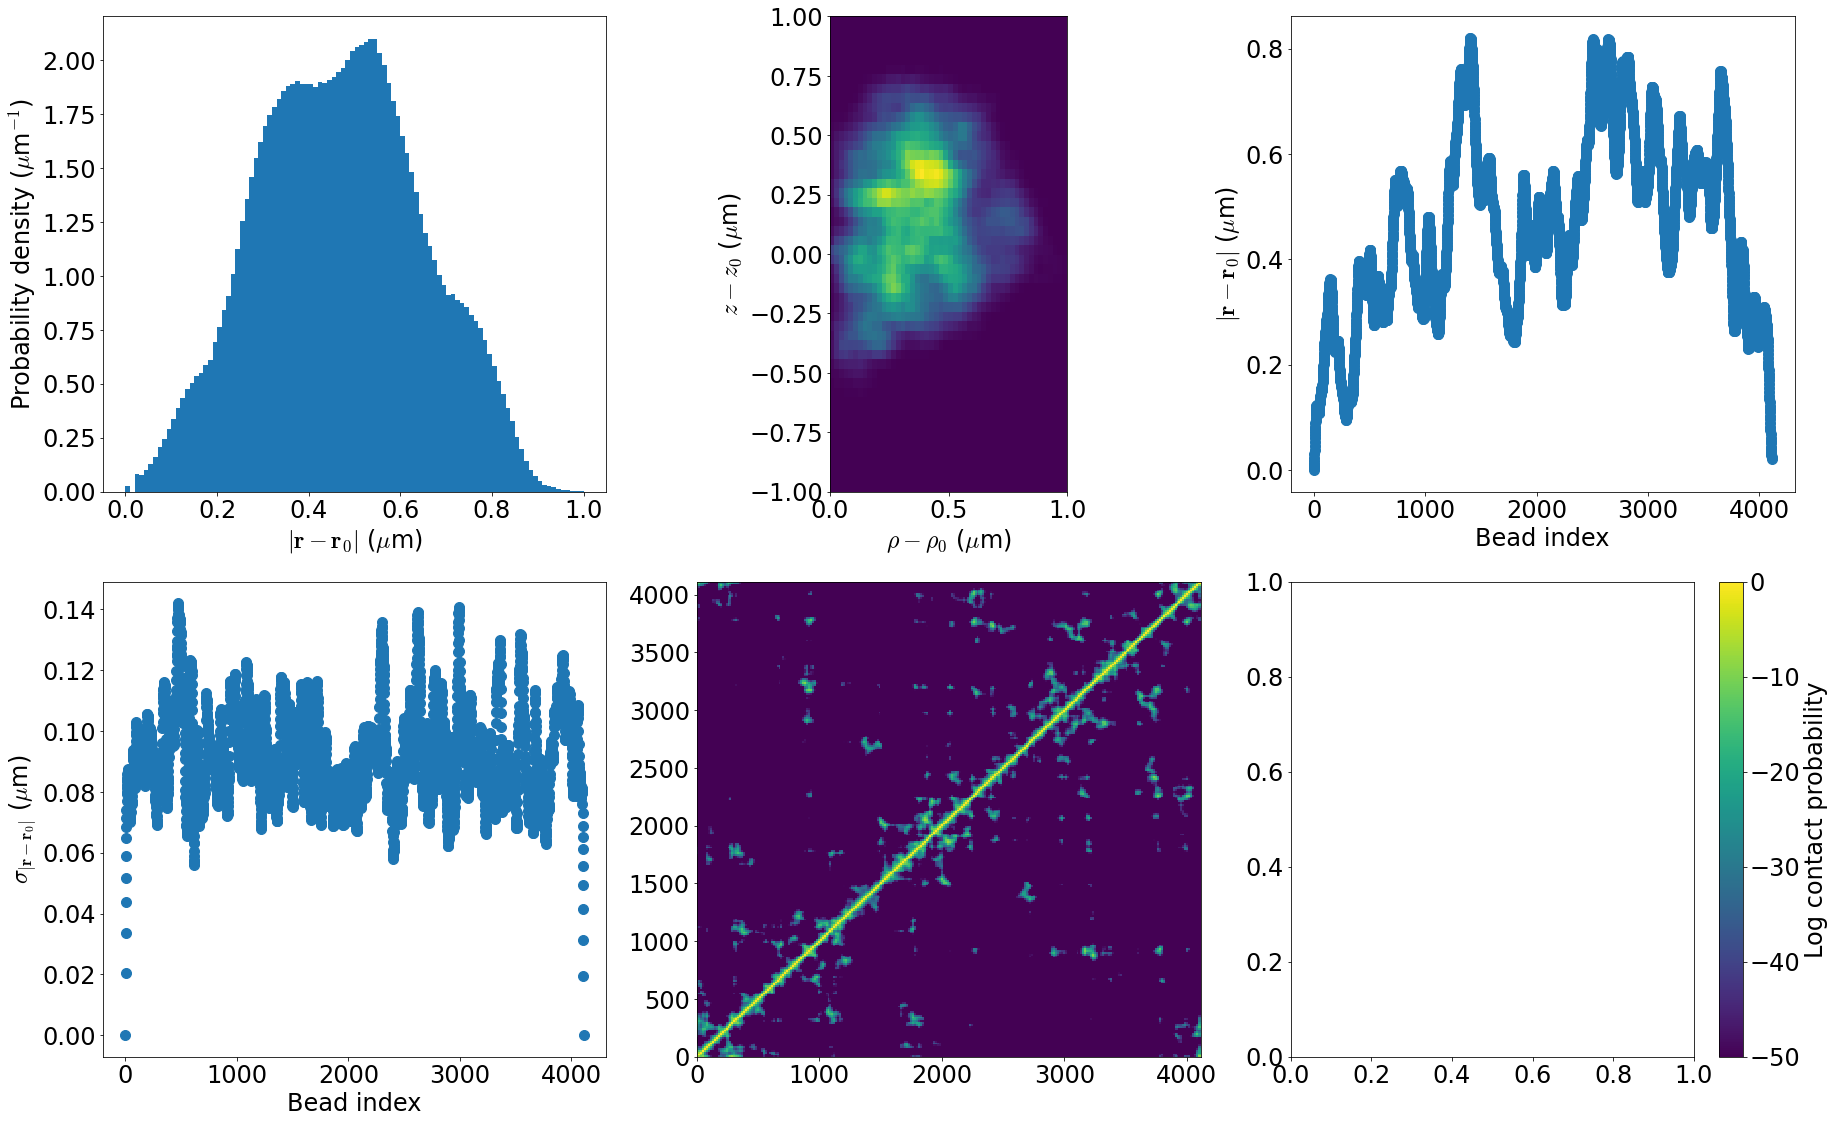

In [91]:
data_path_pin1 = Path("21-04-05_AMchr1_loop4128eq_pin_scan.5/simulations/s1/")
ax[1].set_aspect('equal')
with h5py.File(next(data_path_pin1.glob('*.h5')), 'r+') as h5_data:
    sy_dat = h5_data['raw_data']['sylinders'][...]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
    log_contact_avg_mat = get_time_avg_contact_mat(com_arr, avg_block_step = 16)
    fig, ax = make_total_distr_plots(com_arr, log_contact_avg_mat, hist_max=1.)


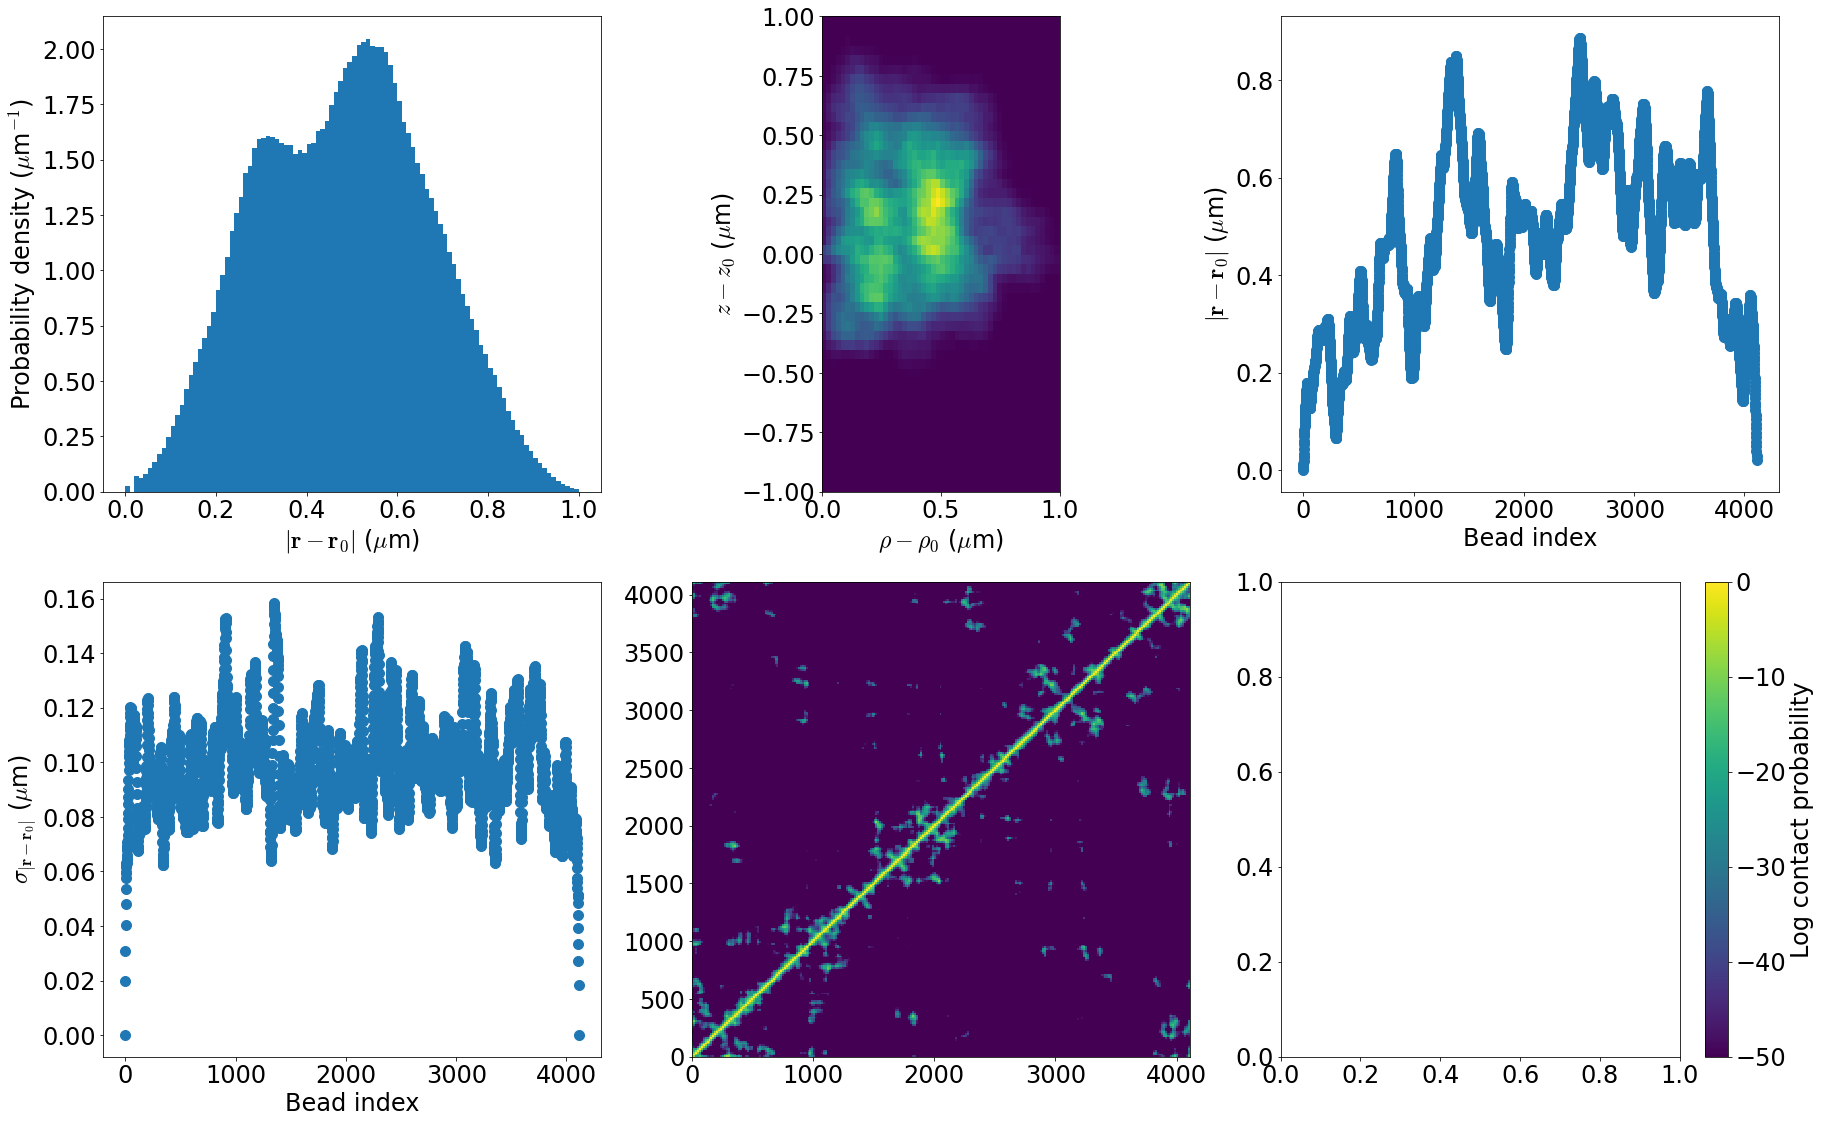

In [92]:
data_path_pin1 = Path("21-04-05_AMchr1_loop4128eq_pin_scan.5/simulations/s2/")
ax[1].set_aspect('equal')
with h5py.File(next(data_path_pin1.glob('*.h5')), 'r+') as h5_data:
    sy_dat = h5_data['raw_data']['sylinders'][...]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
    log_contact_avg_mat = get_time_avg_contact_mat(com_arr, avg_block_step = 16)
    fig, ax = make_total_distr_plots(com_arr, log_contact_avg_mat, hist_max=1.)

# Data/Results

## 32768 loop

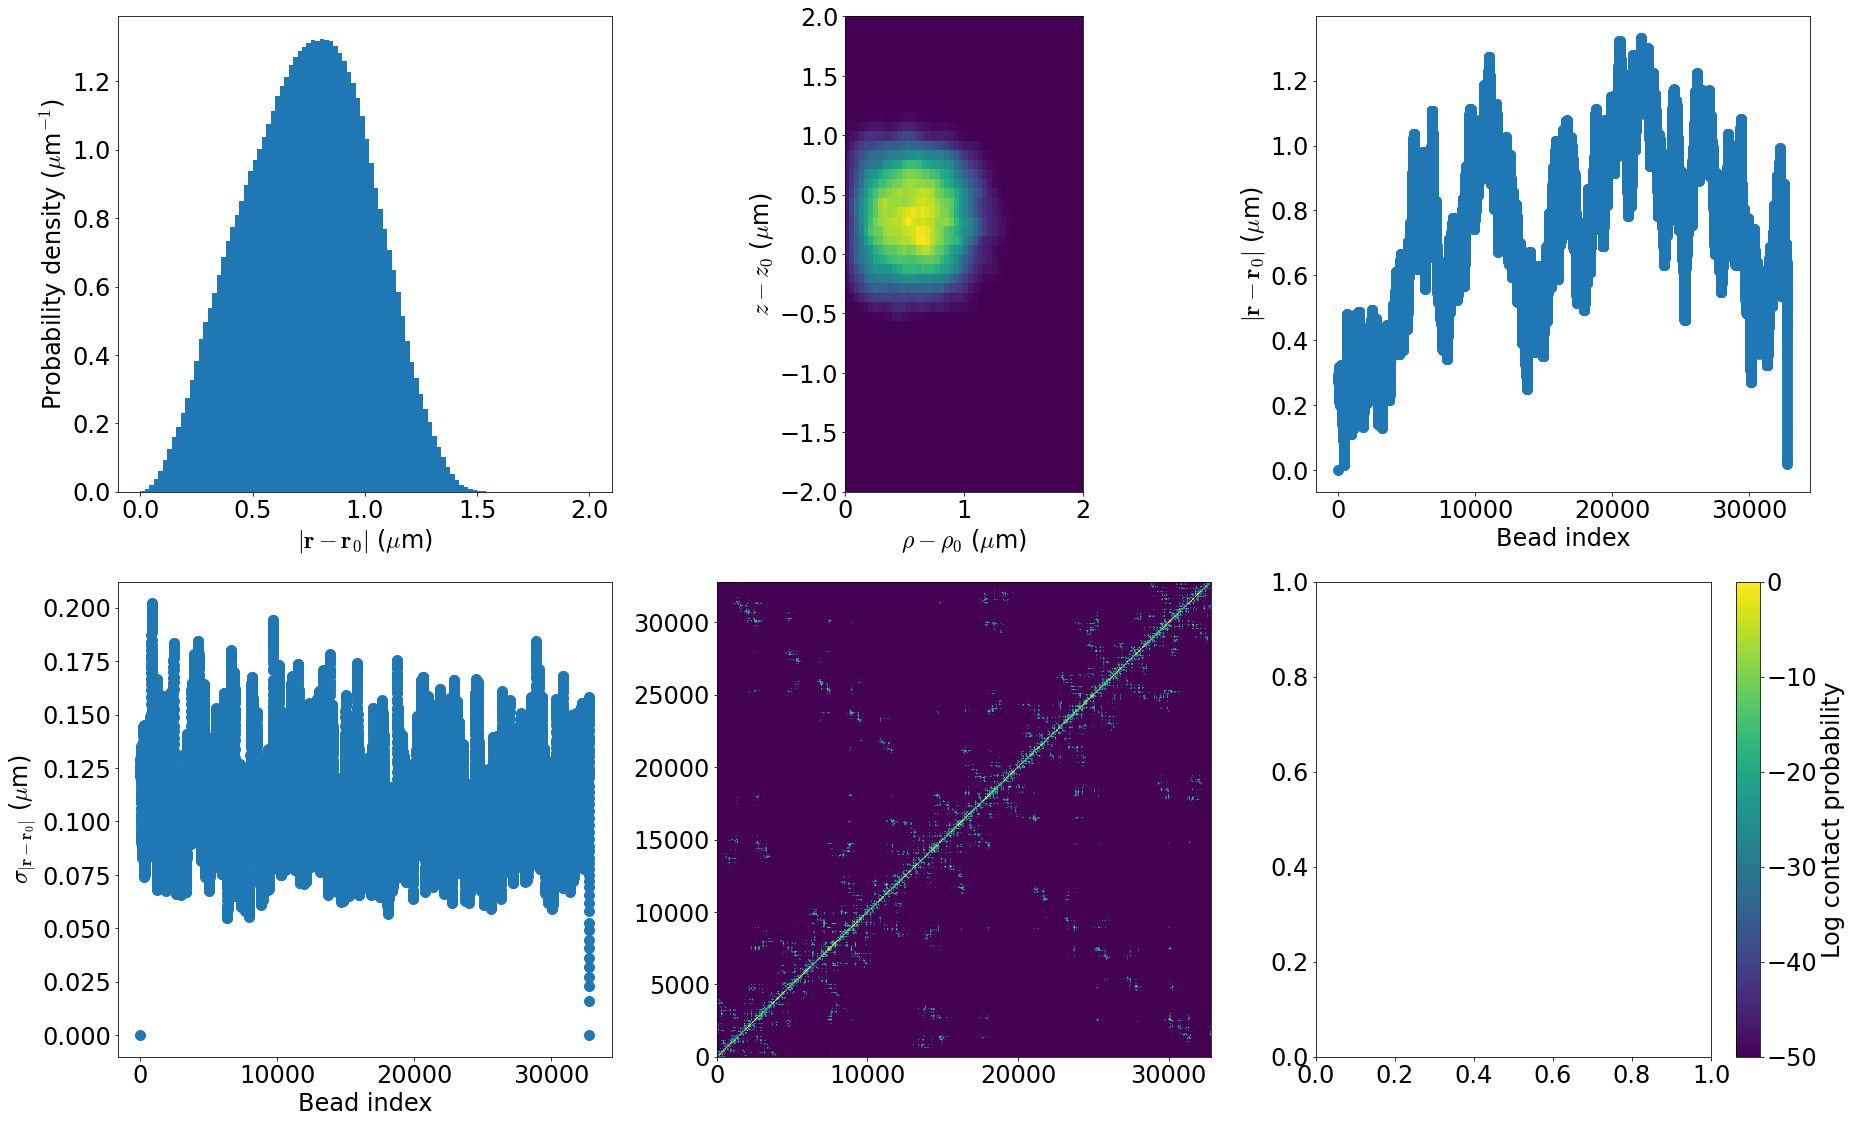

In [104]:
data_path = Path("21-04-02_AMchr1_loop32768_pinned/")
with h5py.File(next(data_path.glob('*.h5')), 'r+') as h5_data:
    sy_dat = h5_data['raw_data']['sylinders'][...]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
    log_contact_avg_mat = get_time_avg_contact_mat(com_arr, avg_block_step = 32)
    fig, ax = make_total_distr_plots(com_arr, log_contact_avg_mat, hist_max=2.)

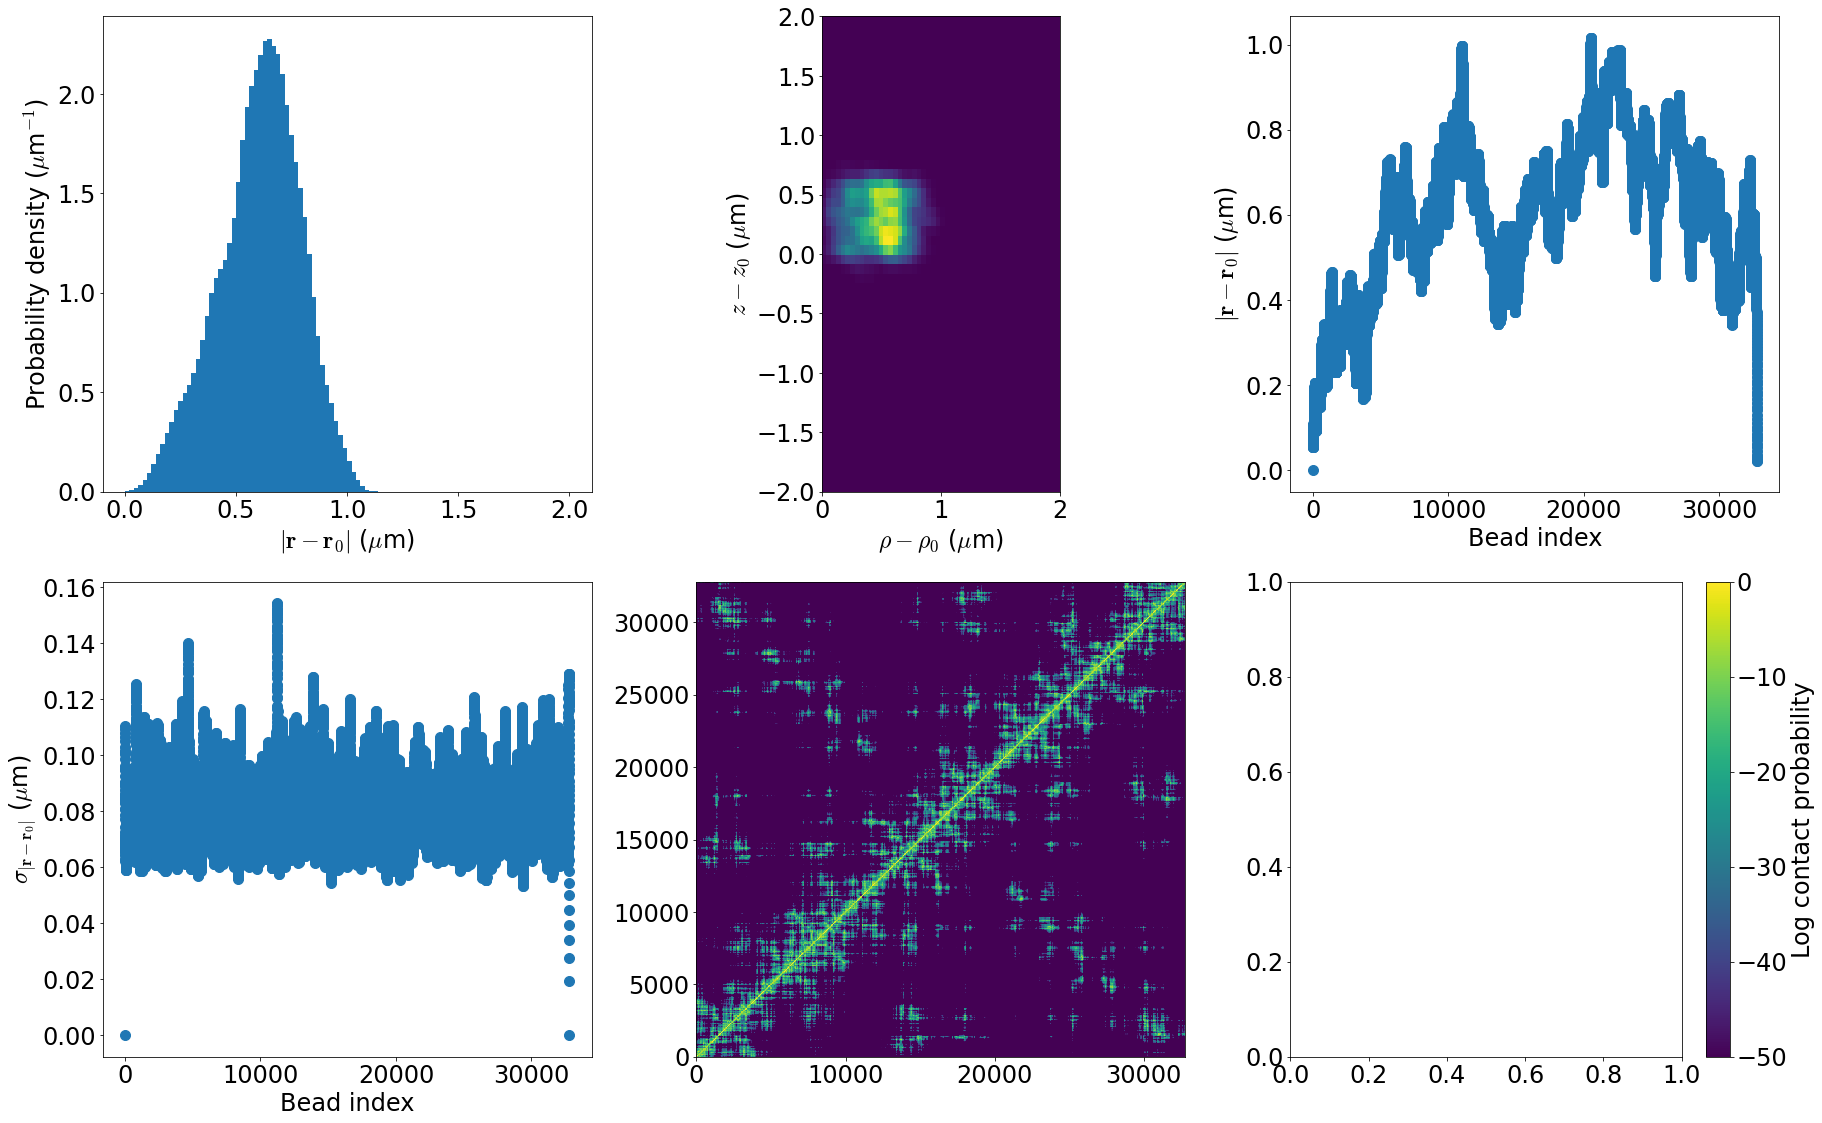

In [98]:
data_path = Path("21-04-02_AMchr1_RS_loop32768_pinned/")
with h5py.File(next(data_path.glob('*.h5')), 'r+') as h5_data:
    sy_dat = h5_data['raw_data']['sylinders'][...]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
    log_contact_avg_mat = get_time_avg_contact_mat(com_arr, avg_block_step = 32)
    fig, ax = make_total_distr_plots(com_arr, log_contact_avg_mat, hist_max=2.)

## SAW 4112 loop seed averages

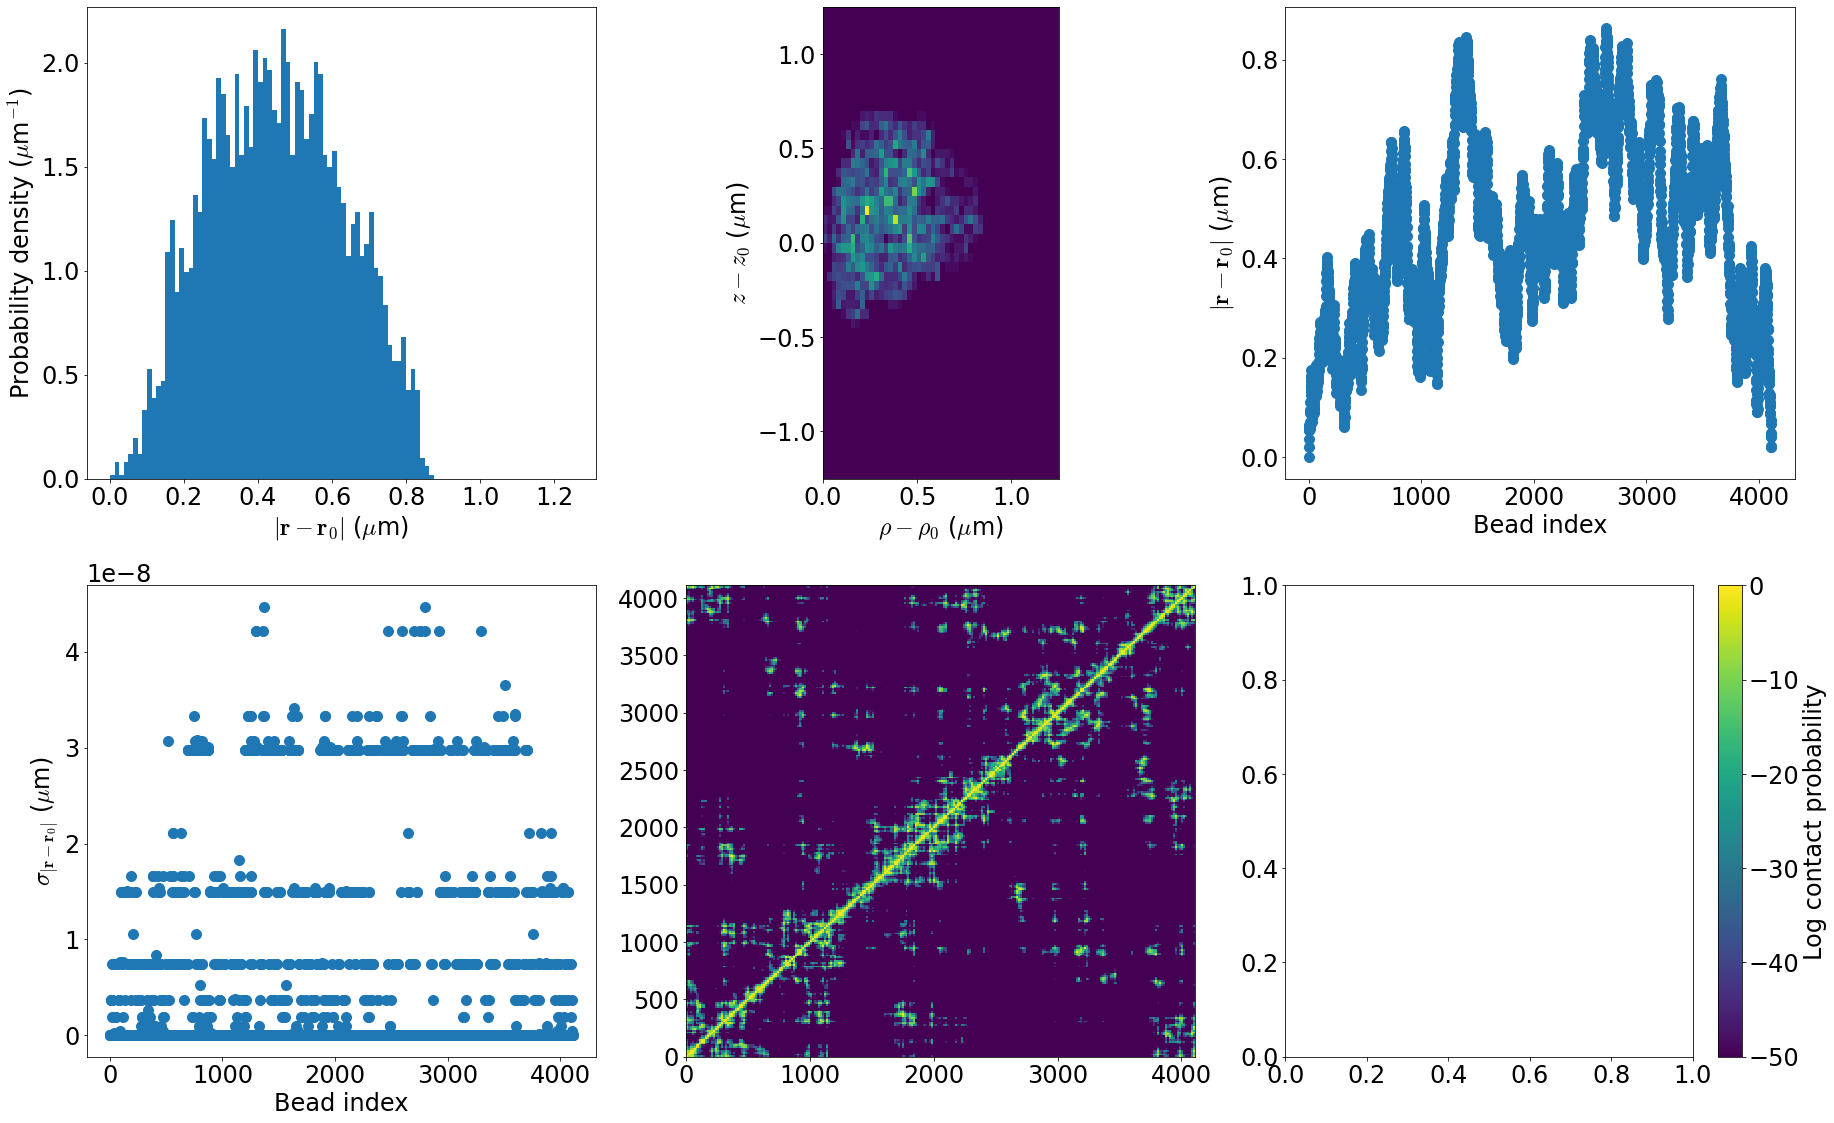

In [162]:
h5_data_paths_pin = Path("21-04-05_AMchr1_loop4128eq_pin_scan.5/simulations/").glob('s*/*.h5')
com_arr = None
ss_ind = 0
for h5_path in h5_data_paths_pin:
    with h5py.File(h5_path, 'r+') as h5_data:
        sy_dat = h5_data['raw_data']['sylinders'][:,:,ss_ind:1]
        if not isinstance(com_arr,np.ndarray):
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            continue
        com_arr = np.append(com_arr, .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :]), axis=-1)
log_contact_avg_mat = get_time_avg_contact_mat(com_arr, avg_block_step = 16)

fig, ax = make_total_distr_plots(com_arr, log_contact_avg_mat, hist_max=1.25)


### Individual beads

<BarContainer object of 100 artists>

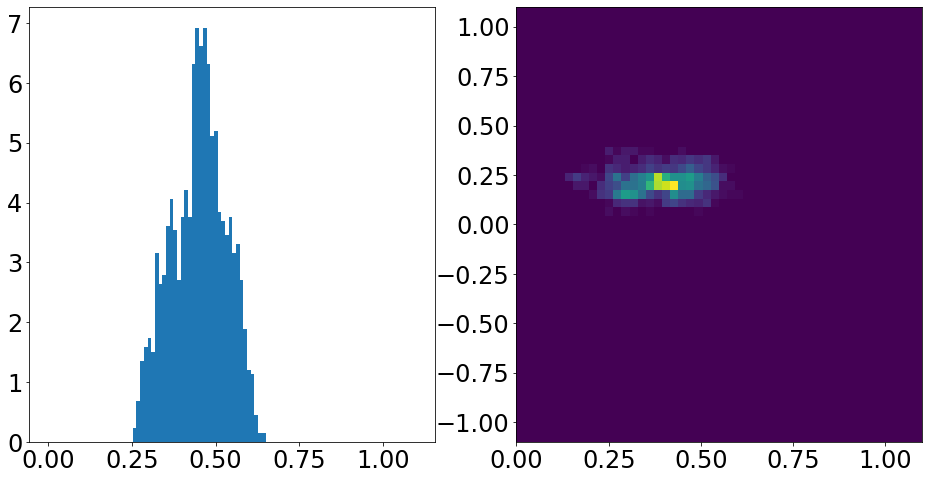

In [36]:
h5_data_paths_pin = Path("21-04-05_AMchr1_loop4128eq_pin_scan.5/simulations/").glob('s*/*.h5')
fig, ax = plt.subplots(1,2, figsize=(16,8))

dist_hist = None
nseeds=0
for h5_path in h5_data_paths_pin:
    with h5py.File(h5_path, 'r+') as h5_data:
        sy_dat = h5_data['raw_data']['sylinders'][...]
        com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
        dist_hist_dat, rho_z_hist_dat = distr_hists(com_arr, free_frac_chain=.5, hist_max=1.1)
        
        if not isinstance(dist_hist,np.ndarray):
            dist_hist = dist_hist_dat[0]
            dist_bin_edges = dist_hist_dat[1]
            
            rho_z_hist = rho_z_hist_dat[0].T
            rho_bin_edges = rho_z_hist_dat[1]
            z_bin_edges = rho_z_hist_dat[2]
            
            continue
            
        dist_hist += dist_hist_dat[0]
        rho_z_hist += rho_z_hist_dat[0].T
    nseeds+=1

dist_hist /= nseeds
rho_z_hist /= nseeds

ax[0].bar(dist_bin_edges[:-1], dist_hist, width=np.diff(dist_bin_edges), align='edge')

X, Y = np.meshgrid(rho_bin_edges, z_bin_edges)
ax[1].pcolormesh(X, Y, rho_z_hist)

<BarContainer object of 100 artists>

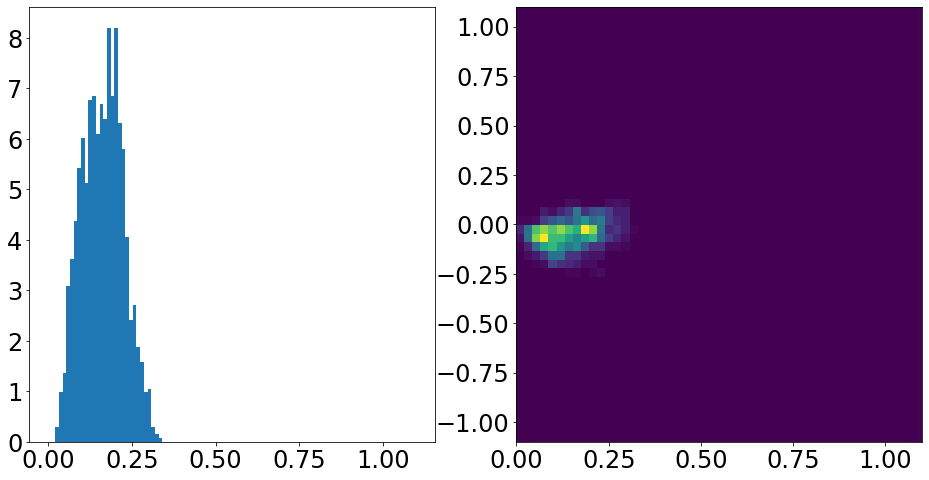

In [38]:
h5_data_paths_pin = Path("21-04-05_AMchr1_loop4128eq_pin_scan.5/simulations/").glob('s*/*.h5')
fig, ax = plt.subplots(1,2, figsize=(16,8))

dist_hist = None
nseeds=0
for h5_path in h5_data_paths_pin:
    with h5py.File(h5_path, 'r+') as h5_data:
        sy_dat = h5_data['raw_data']['sylinders'][...]
        com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
        dist_hist_dat, rho_z_hist_dat = distr_hists(com_arr, free_frac_chain=.01, hist_max=1.1)
        
        if not isinstance(dist_hist,np.ndarray):
            dist_hist = dist_hist_dat[0]
            dist_bin_edges = dist_hist_dat[1]
            
            rho_z_hist = rho_z_hist_dat[0].T
            rho_bin_edges = rho_z_hist_dat[1]
            z_bin_edges = rho_z_hist_dat[2]
       
            continue
            
        dist_hist += dist_hist_dat[0]
        rho_z_hist += rho_z_hist_dat[0].T
       
    nseeds+=1

dist_hist /= nseeds
rho_z_hist /= nseeds

ax[0].bar(dist_bin_edges[:-1], dist_hist, width=np.diff(dist_bin_edges), align='edge')

X, Y = np.meshgrid(rho_bin_edges, z_bin_edges)
ax[1].pcolormesh(X, Y, rho_z_hist)


<BarContainer object of 100 artists>

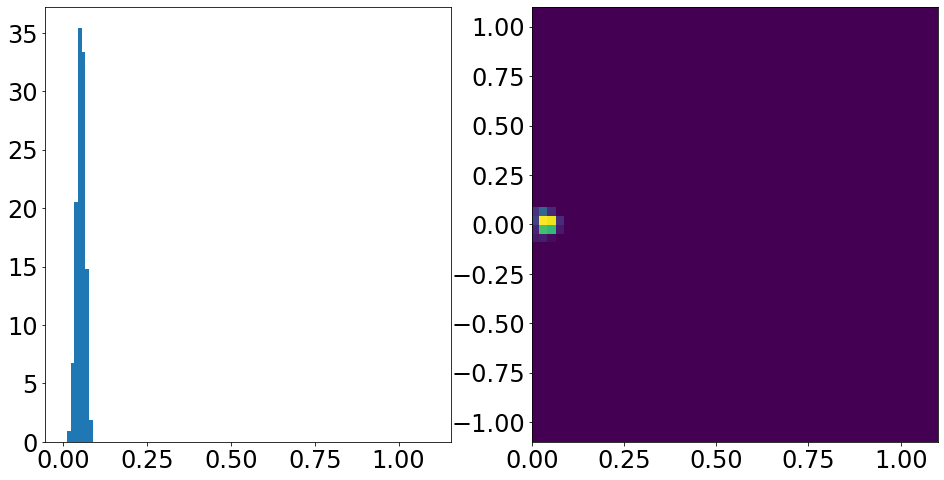

In [39]:
h5_data_paths_pin = Path("21-04-05_AMchr1_loop4128eq_pin_scan.5/simulations/").glob('s*/*.h5')
fig, ax = plt.subplots(1,2, figsize=(16,8))

dist_hist = None
nseeds=0
for h5_path in h5_data_paths_pin:
    with h5py.File(h5_path, 'r+') as h5_data:
        sy_dat = h5_data['raw_data']['sylinders'][...]
        com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
        dist_hist_dat, rho_z_hist_dat = distr_hists(com_arr, free_frac_chain=.001, hist_max=1.1)
        
        if not isinstance(dist_hist,np.ndarray):
            dist_hist = dist_hist_dat[0]
            dist_bin_edges = dist_hist_dat[1]
            
            rho_z_hist = rho_z_hist_dat[0].T
            rho_bin_edges = rho_z_hist_dat[1]
            z_bin_edges = rho_z_hist_dat[2]
            
            continue
            
        dist_hist += dist_hist_dat[0]
        rho_z_hist += rho_z_hist_dat[0].T
    nseeds+=1

dist_hist /= nseeds
rho_z_hist /= nseeds

ax[0].bar(dist_bin_edges[:-1], dist_hist, width=np.diff(dist_bin_edges), align='edge')

X, Y = np.meshgrid(rho_bin_edges, z_bin_edges)
ax[1].pcolormesh(X, Y, rho_z_hist)

## Rouse 4112 loop seed averages

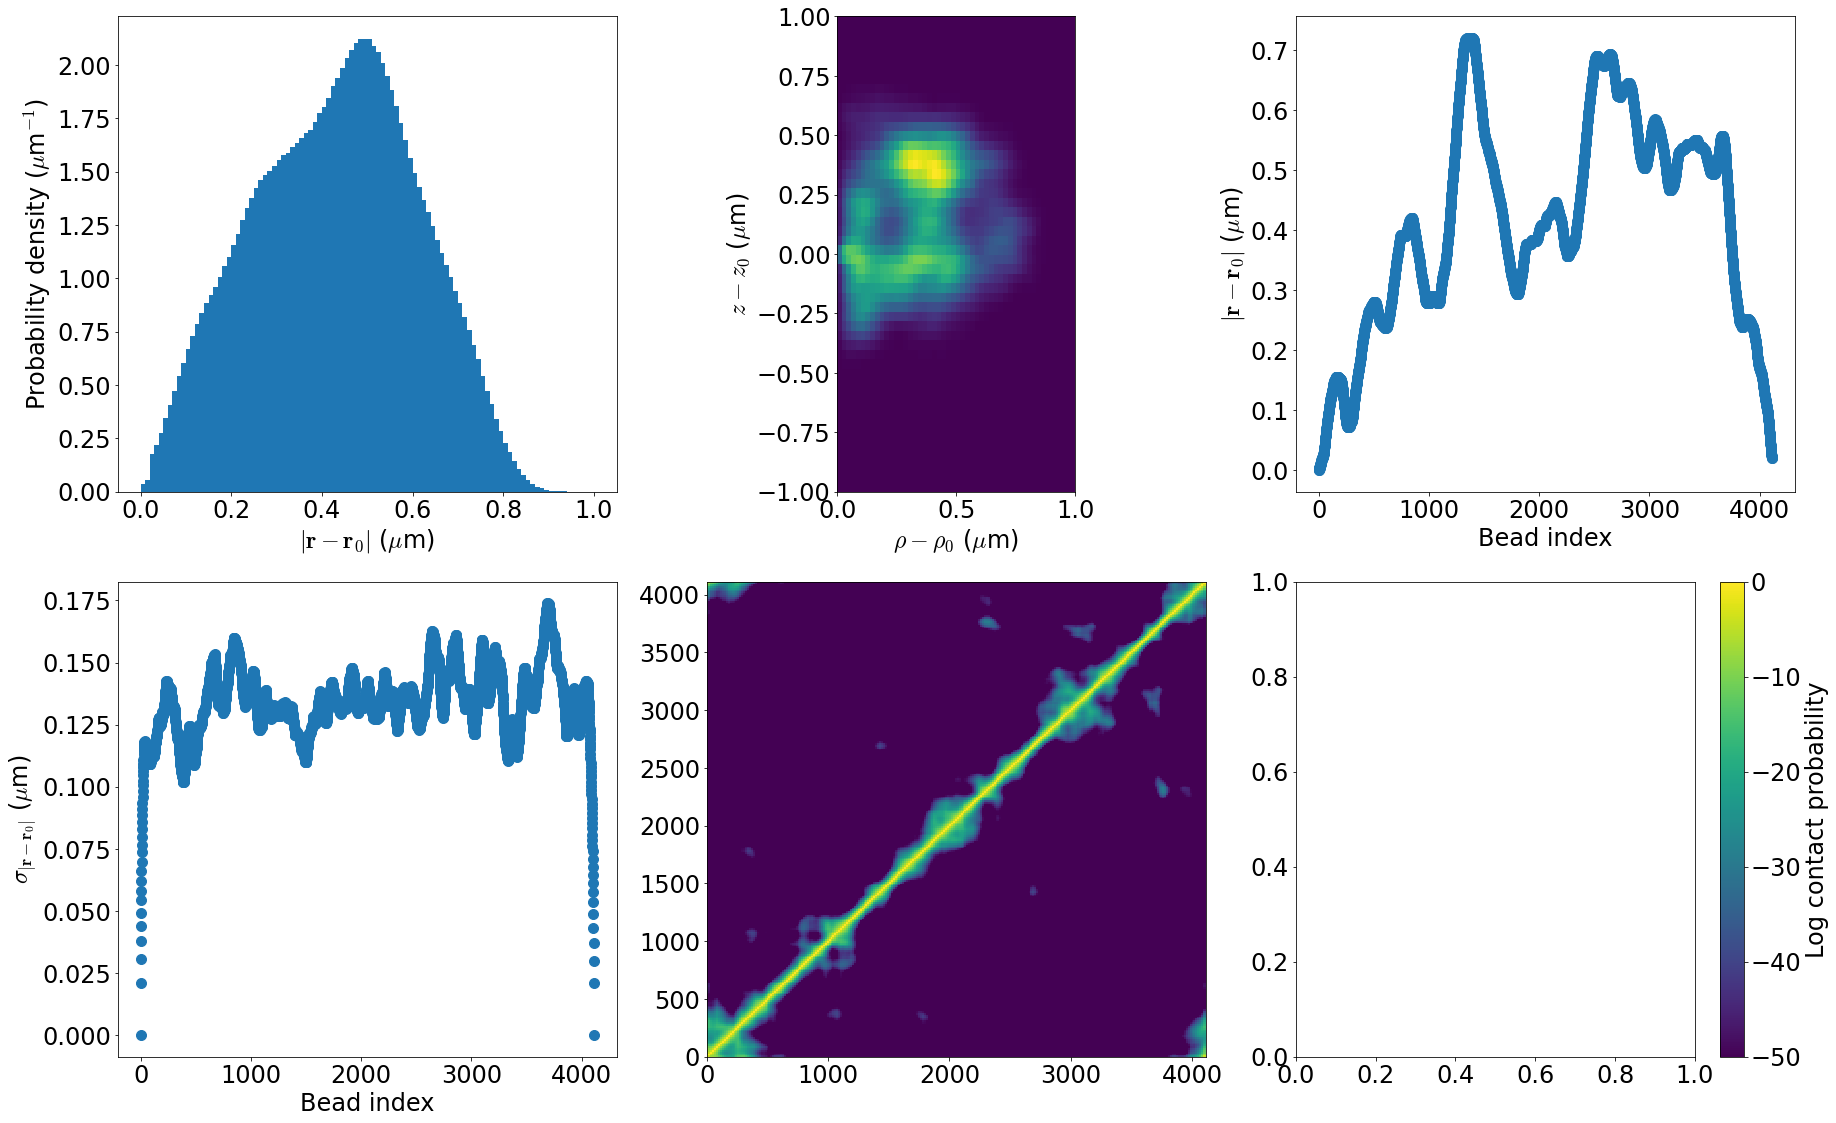

In [69]:
h5_data_paths_pin = Path("21-04-05_AMchr1_RS_loop4128eq_pin_scan.5/simulations/").glob('s*/*.h5')
com_arr = None
for h5_path in h5_data_paths_pin:
    with h5py.File(h5_path, 'r+') as h5_data:
        sy_dat = h5_data['raw_data']['sylinders'][...]
        if not isinstance(com_arr,np.ndarray):
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            continue
        com_arr = np.append(com_arr, .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :]), axis=-1)
log_contact_avg_mat = get_time_avg_contact_mat(com_arr, avg_block_step = 16)

fig, ax = make_total_distr_plots(com_arr, log_contact_avg_mat, hist_max=1.)


## SAW 2 loop pin

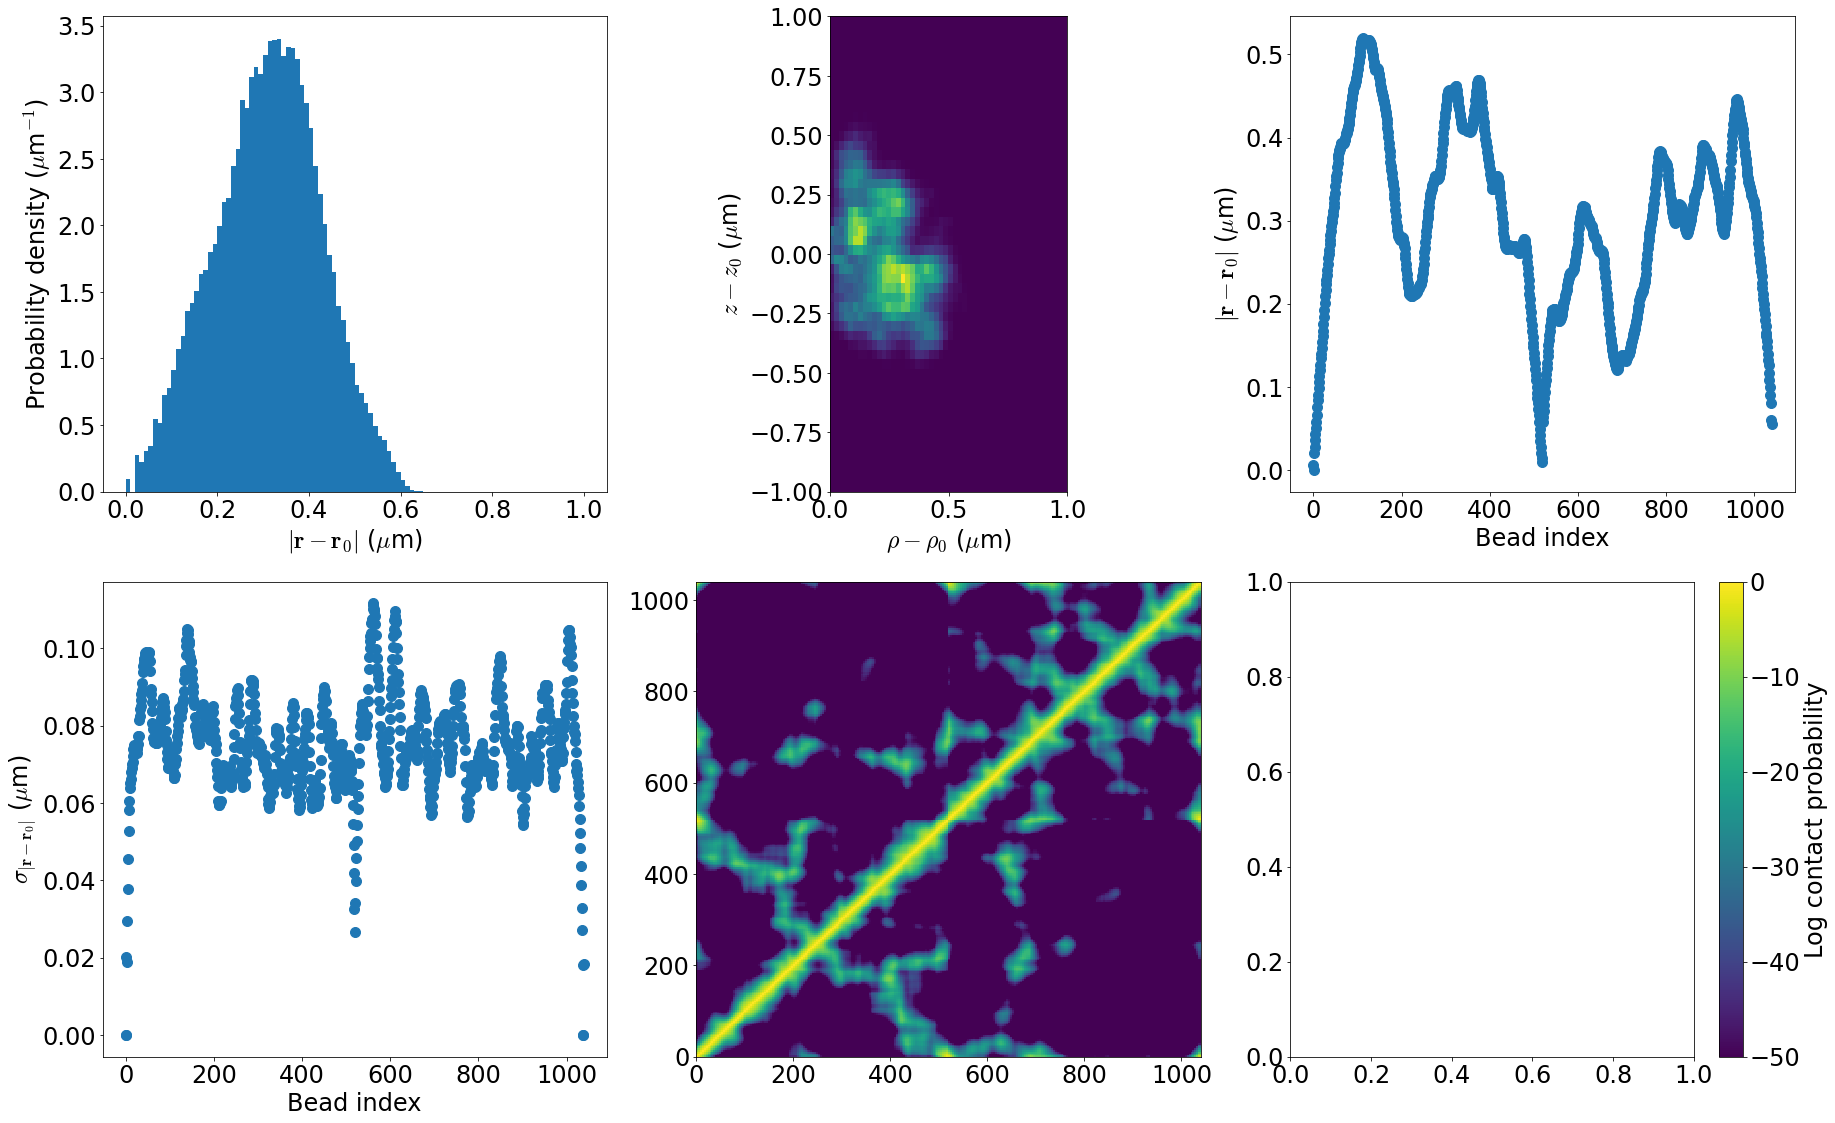

In [202]:
data_path = Path("21-04-09_AMchr1_2loop1000_pin_conf1.2/")
ss_ind = 300
with h5py.File(next(data_path.glob('*.h5')), 'r+') as h5_data:
    sy_dat = h5_data['raw_data']['sylinders'][:,:,ss_ind:]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])[:,:,int(sy_dat.shape[-1]*.5):]
    log_contact_avg_mat = get_time_avg_contact_mat(com_arr, avg_block_step = 4)
    fig, ax = make_total_distr_plots(com_arr, log_contact_avg_mat, hist_max=1., rel_ind=1)

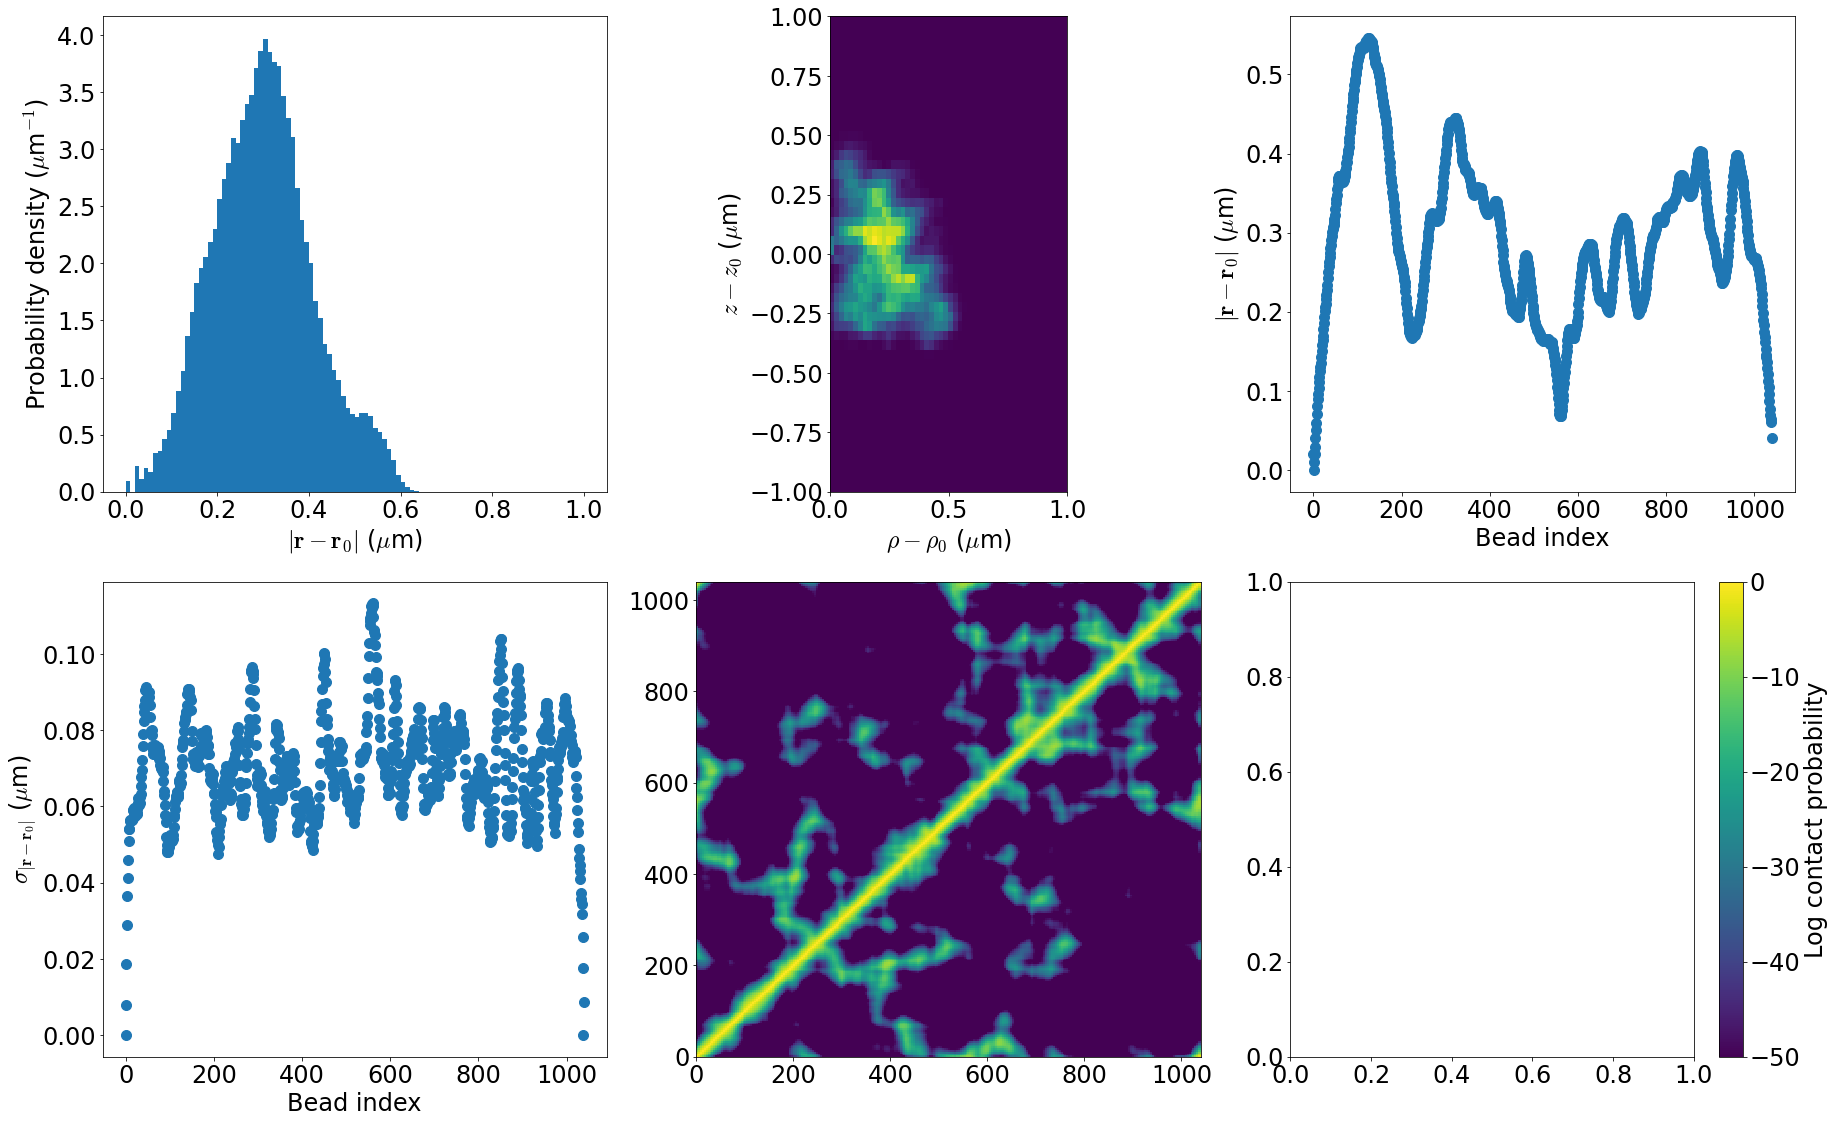

In [221]:
data_path = Path("21-04-09_AMchr1_loop1000_pin_conf1.2/")
ss_ind = 300
with h5py.File(next(data_path.glob('*.h5')), 'r+') as h5_data:
    sy_dat = h5_data['raw_data']['sylinders'][:,:,ss_ind:]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])[:,:,int(sy_dat.shape[-1]*.5):]
    log_contact_avg_mat = get_time_avg_contact_mat(com_arr, avg_block_step = 4)
    fig, ax = make_total_distr_plots(com_arr, log_contact_avg_mat, hist_max=1., rel_ind=1)

## Rouse 2 loop pinned 

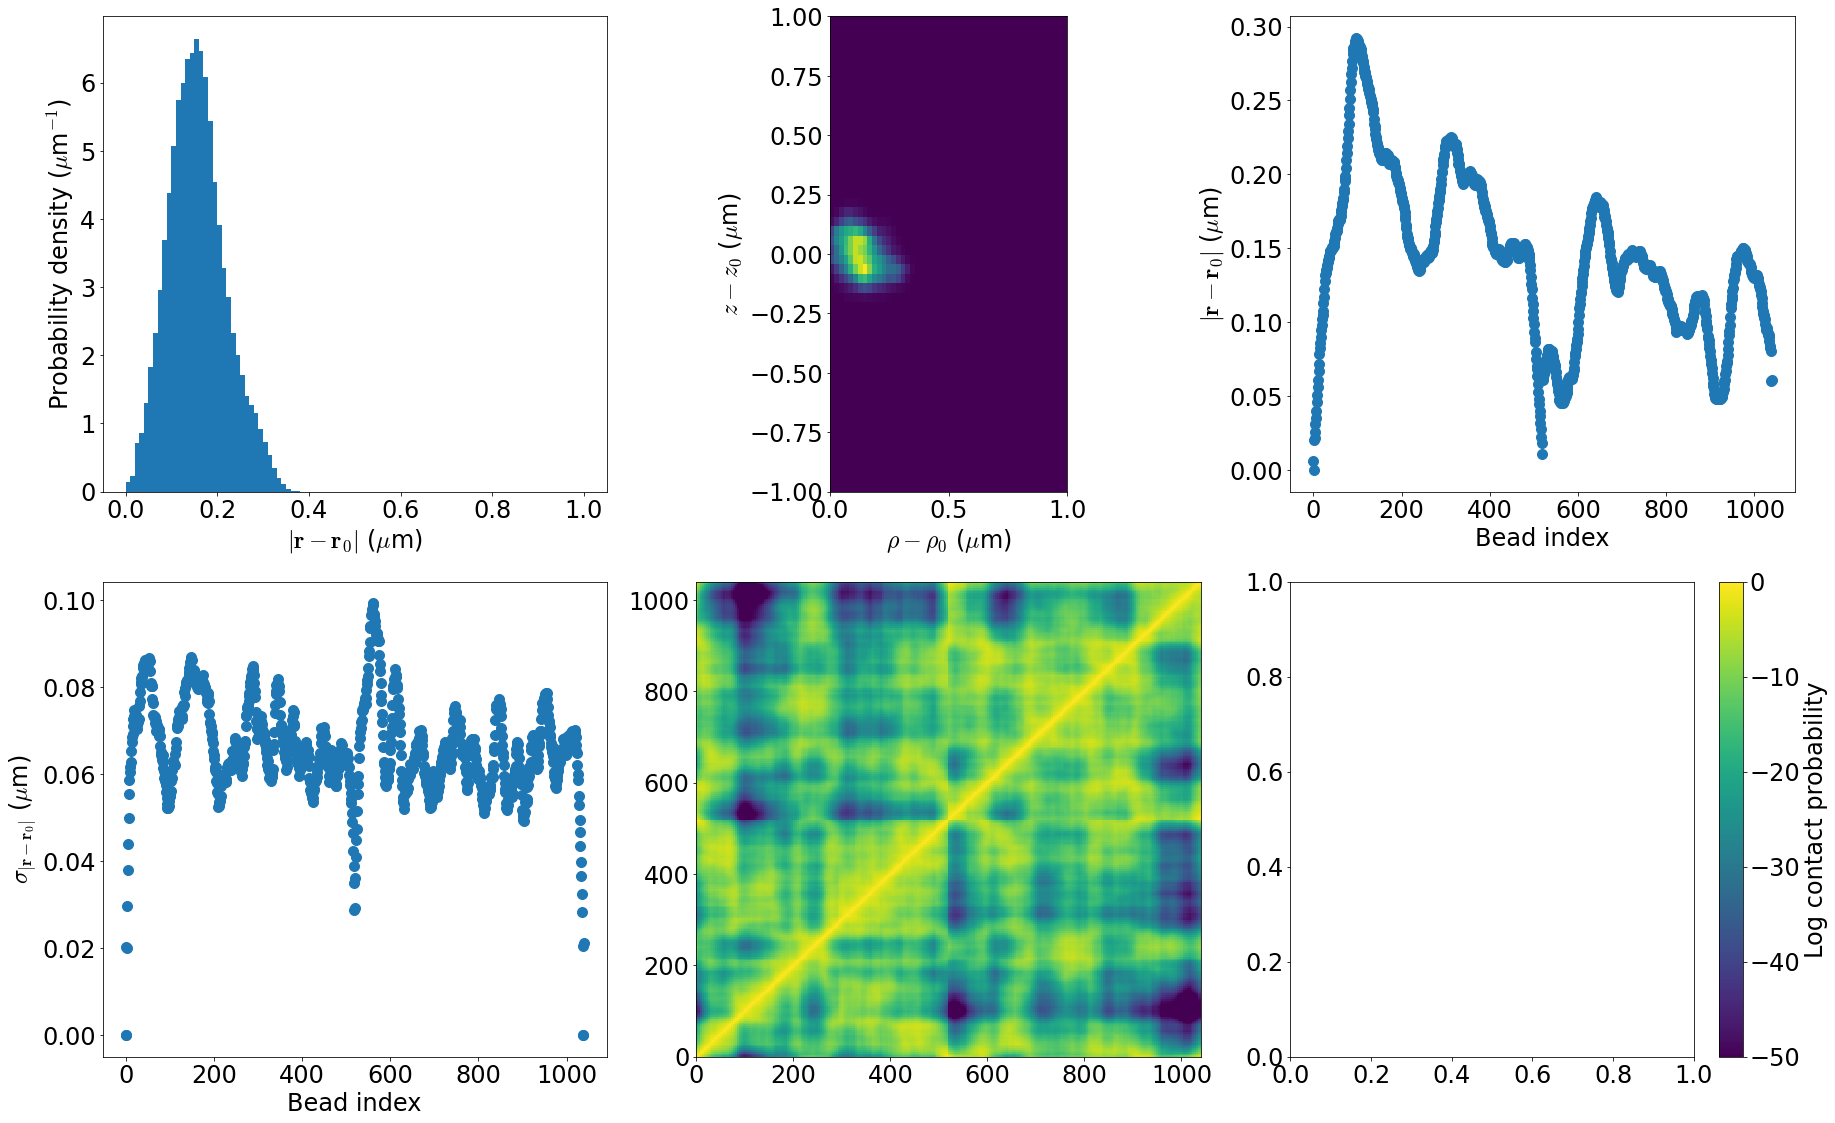

In [217]:
data_path = Path("21-04-09_AMchr1_RS_2loop1000_pin_conf1.2/")
ss_ind = 300
with h5py.File(next(data_path.glob('*.h5')), 'r+') as h5_data:
    sy_dat = h5_data['raw_data']['sylinders'][:,:,ss_ind:]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])[:,:,int(sy_dat.shape[-1]*.5):]
    log_contact_avg_mat = get_time_avg_contact_mat(com_arr, avg_block_step = 4)
    fig, ax = make_total_distr_plots(com_arr, log_contact_avg_mat, hist_max=1., rel_ind=1)

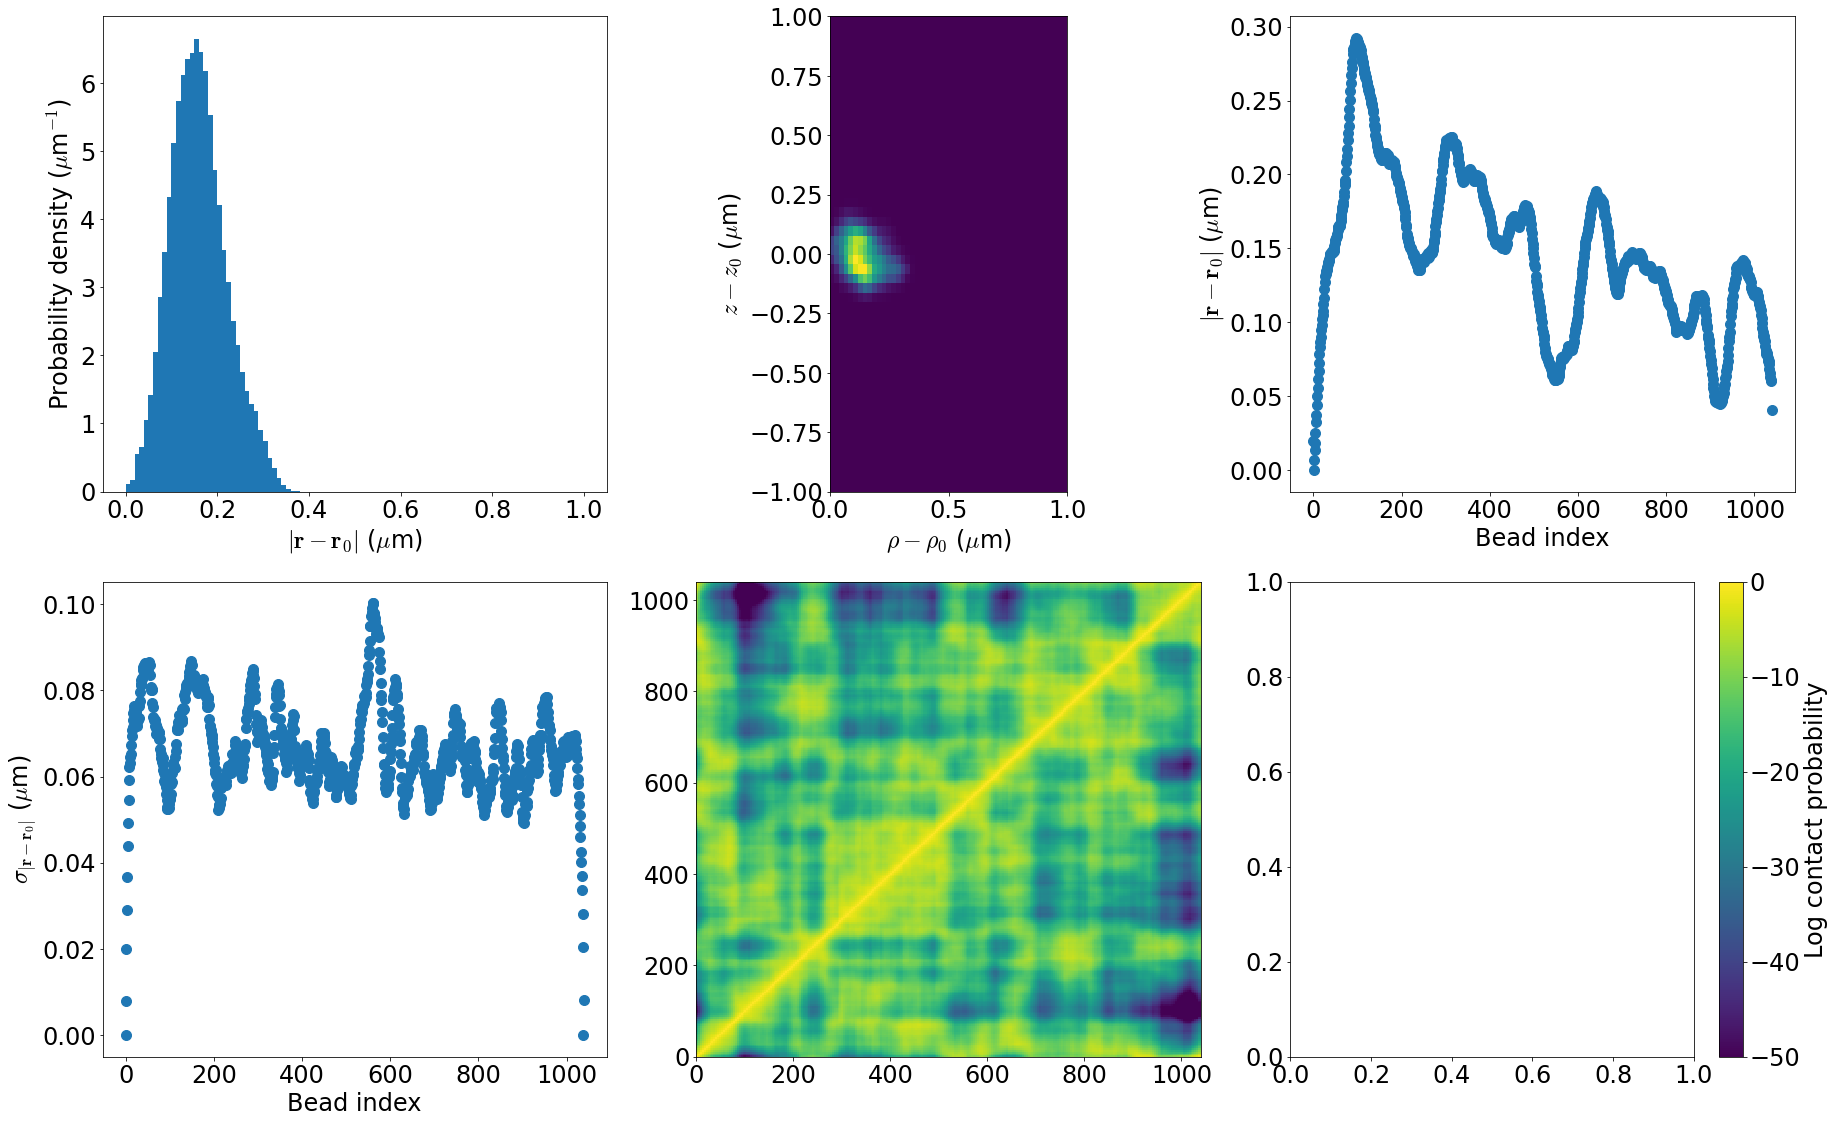

In [222]:
data_path = Path("21-04-09_AMchr1_RS_loop1000_pin_conf1.2/")
ss_ind = 300
with h5py.File(next(data_path.glob('*.h5')), 'r+') as h5_data:
    sy_dat = h5_data['raw_data']['sylinders'][:,:,ss_ind:]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])[:,:,int(sy_dat.shape[-1]*.5):]
    log_contact_avg_mat = get_time_avg_contact_mat(com_arr, avg_block_step = 4)
    fig, ax = make_total_distr_plots(com_arr, log_contact_avg_mat, hist_max=1., rel_ind=1)

## SAW 4112 confined loop scans

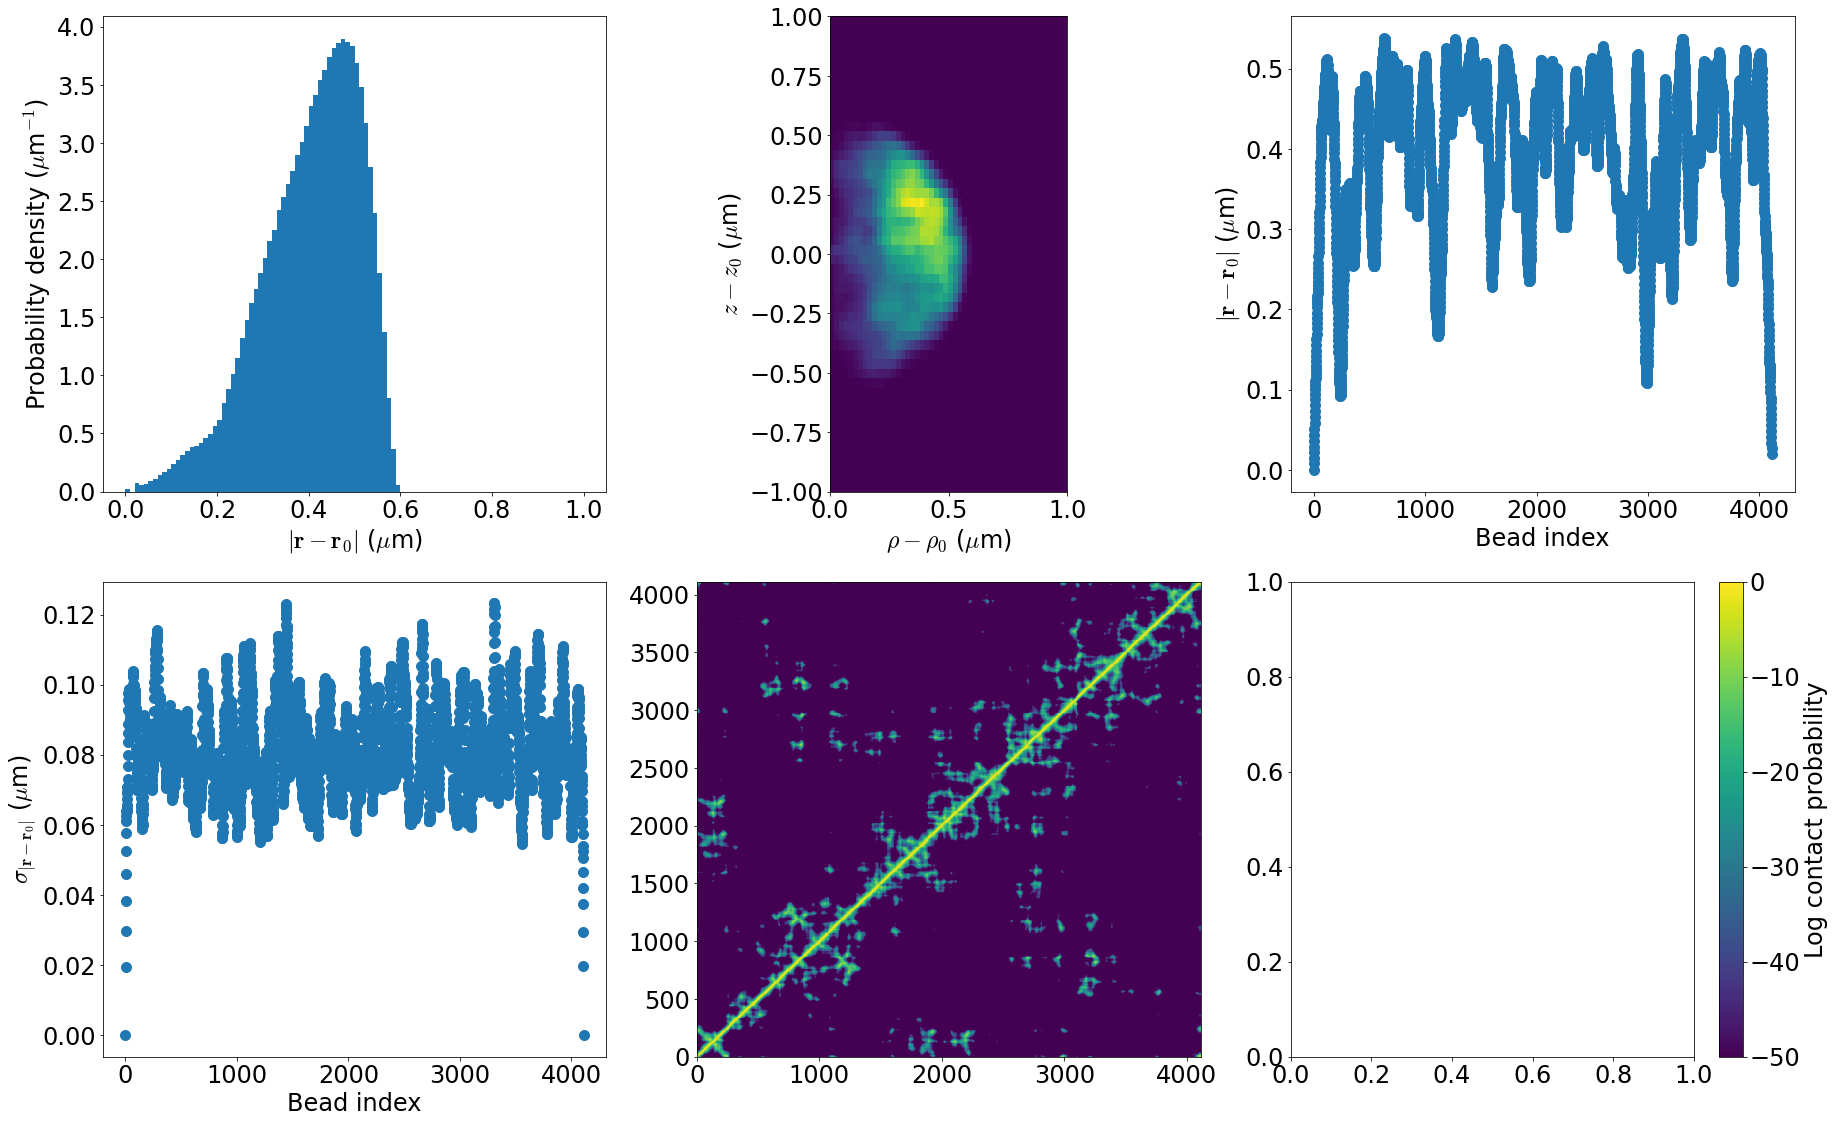

In [209]:
data_path = Path("21-04-06_AMchr1_loop4112_pin_scan_conf.6-5/simulations/Rconf0.6/")
ss_ind = 1000
with h5py.File(next(data_path.glob('*.h5')), 'r+') as h5_data:
    sy_dat = h5_data['raw_data']['sylinders'][:,:,ss_ind:]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
    log_contact_avg_mat = get_time_avg_contact_mat(com_arr, avg_block_step = 8)
    fig, ax = make_total_distr_plots(com_arr, log_contact_avg_mat, hist_max=1.)

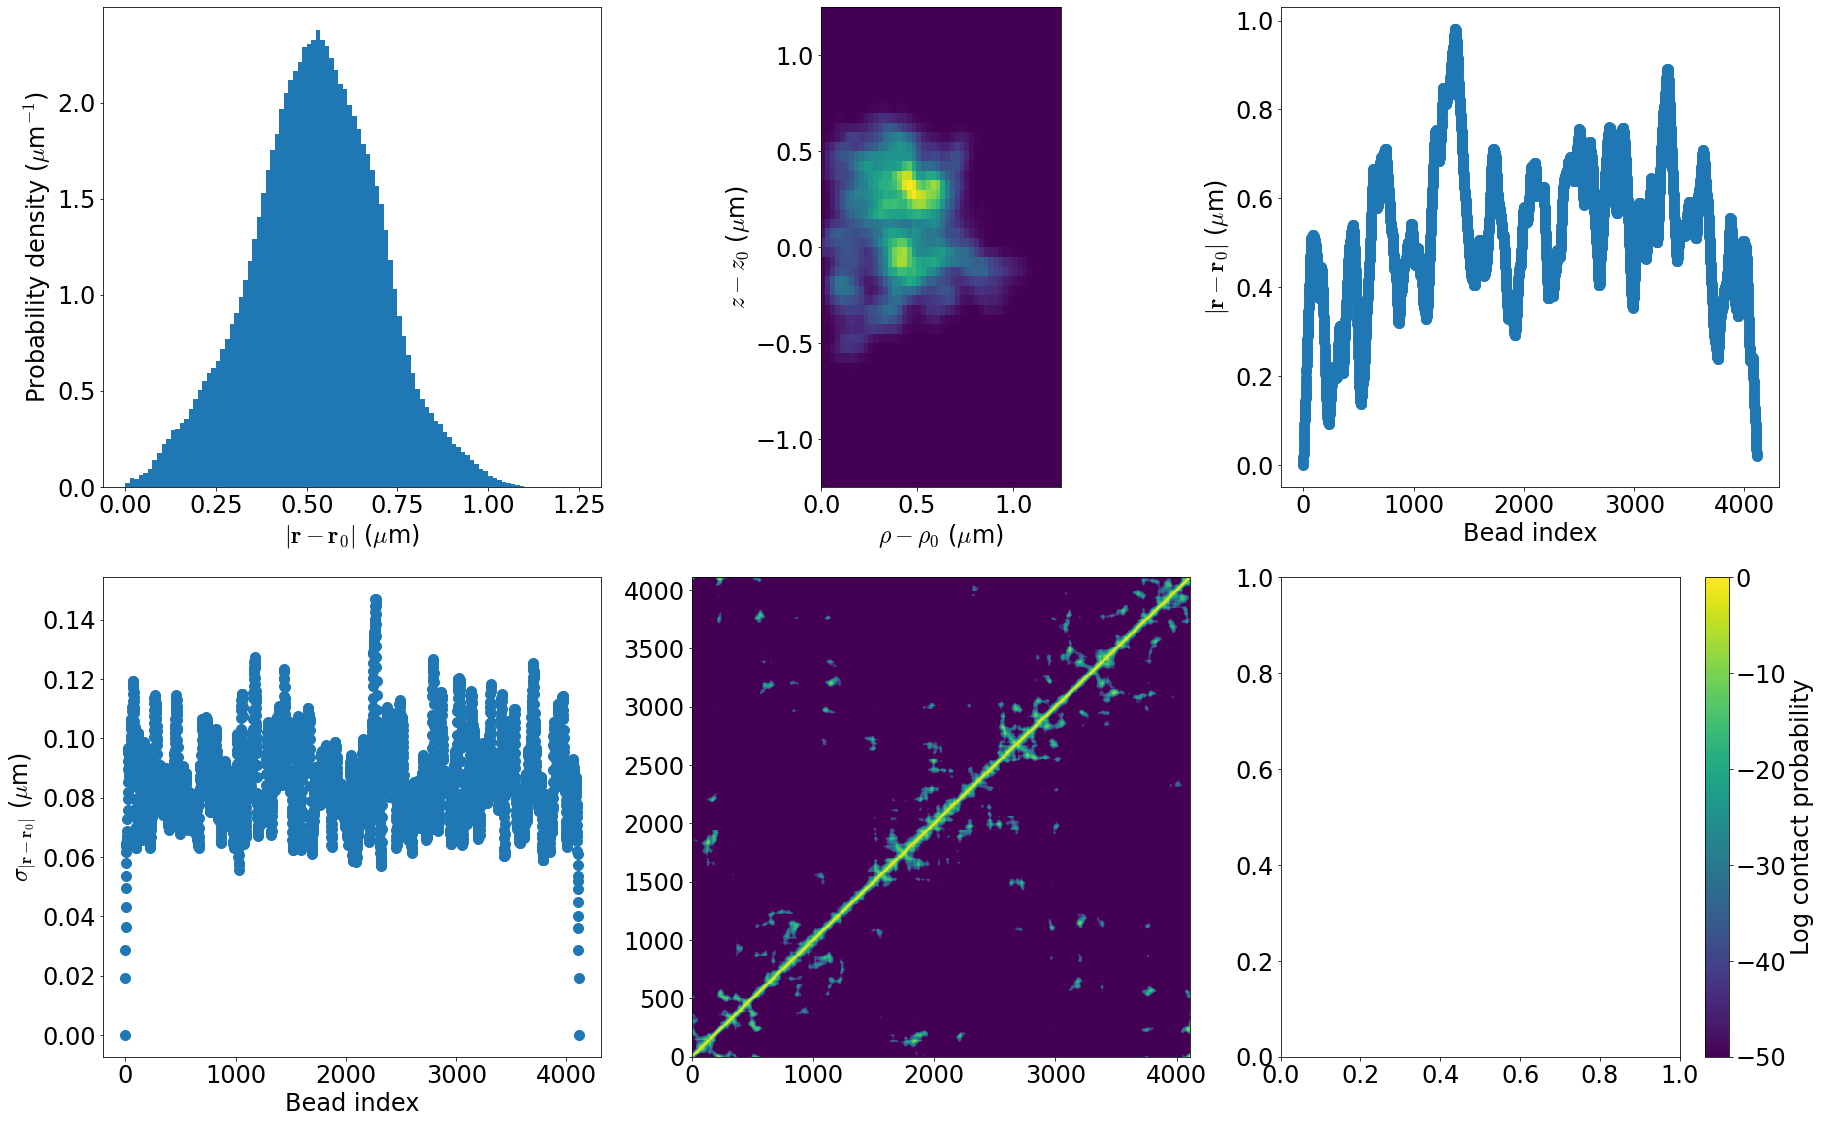

In [210]:
data_path = Path("21-04-06_AMchr1_loop4112_pin_scan_conf.6-5/simulations/Rconf1.25/")
ss_ind = 1000
with h5py.File(next(data_path.glob('*.h5')), 'r+') as h5_data:
    sy_dat = h5_data['raw_data']['sylinders'][:,:,ss_ind:]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
    log_contact_avg_mat = get_time_avg_contact_mat(com_arr, avg_block_step = 8)
    fig, ax = make_total_distr_plots(com_arr, log_contact_avg_mat, hist_max=1.25)

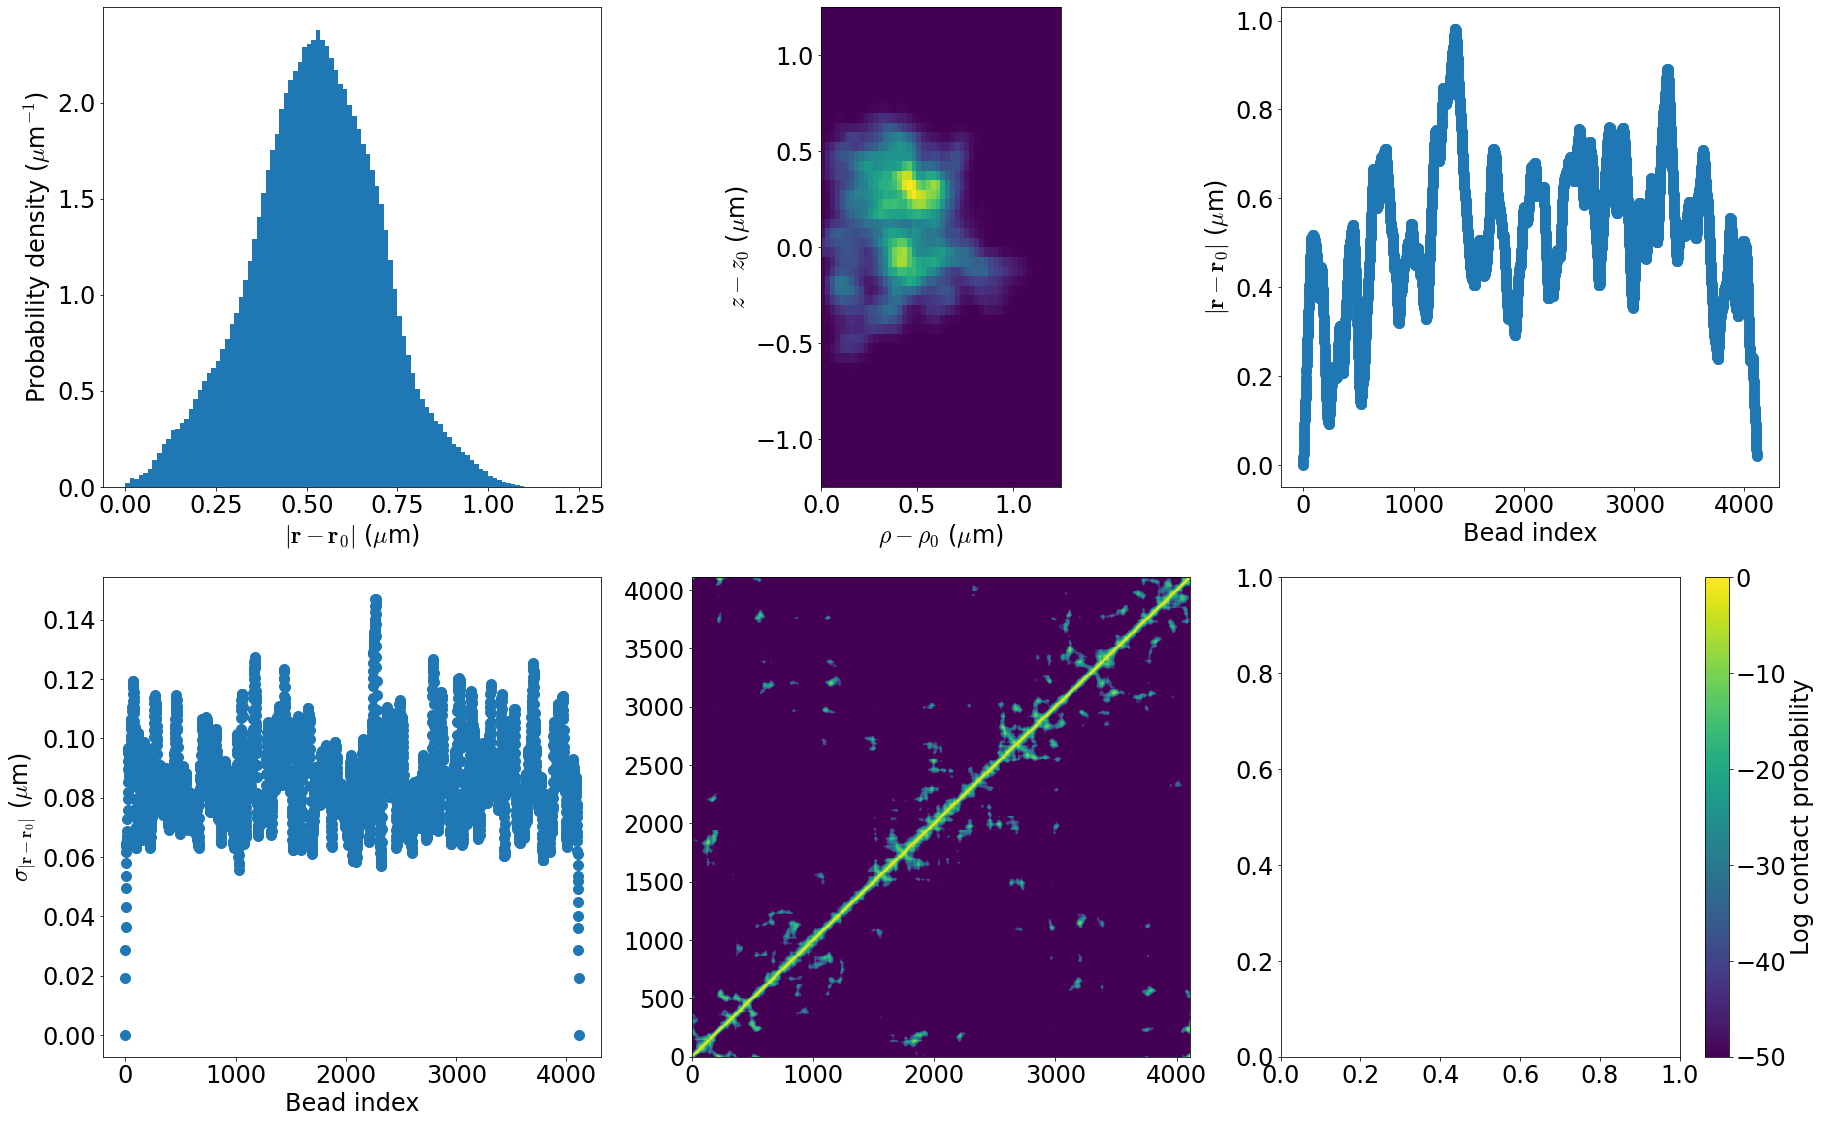

In [213]:
data_path = Path("21-04-06_AMchr1_loop4112_pin_scan_conf.6-5/simulations/Rconf2.5/")
ss_ind = 1000
with h5py.File(next(data_path.glob('*.h5')), 'r+') as h5_data:
    sy_dat = h5_data['raw_data']['sylinders'][:,:,ss_ind:]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
    log_contact_avg_mat = get_time_avg_contact_mat(com_arr, avg_block_step = 8)
    fig, ax = make_total_distr_plots(com_arr, log_contact_avg_mat, hist_max=1.25)

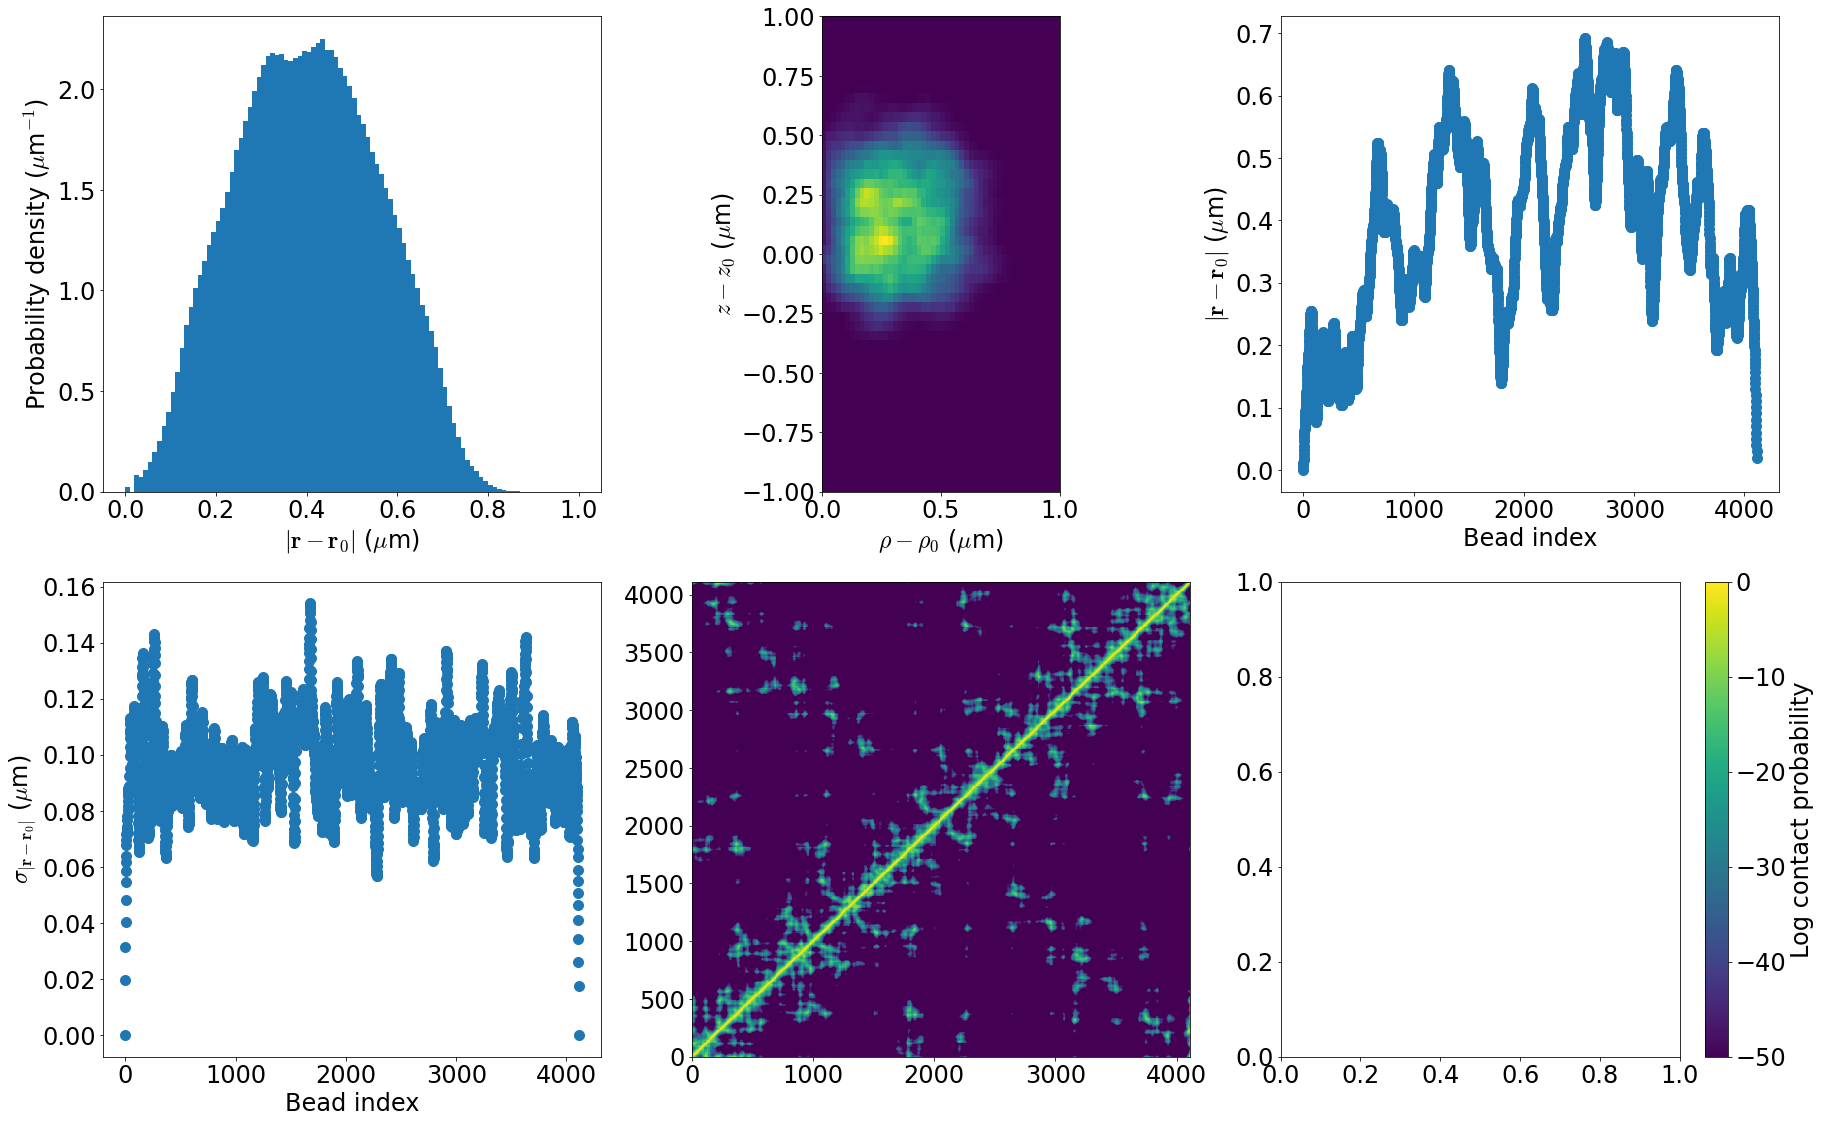

In [80]:
data_path = Path("21-04-06_AMchr1_loop4112_pin_scan_conf.6-5/simulations/Rconf5/")
with h5py.File(next(data_path.glob('*.h5')), 'r+') as h5_data:
    sy_dat = h5_data['raw_data']['sylinders'][...]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
    log_contact_avg_mat = get_time_avg_contact_mat(com_arr, avg_block_step = 8)
    fig, ax = make_total_distr_plots(com_arr, log_contact_avg_mat, hist_max=1.)

## Rouse 4112 confined loop scans

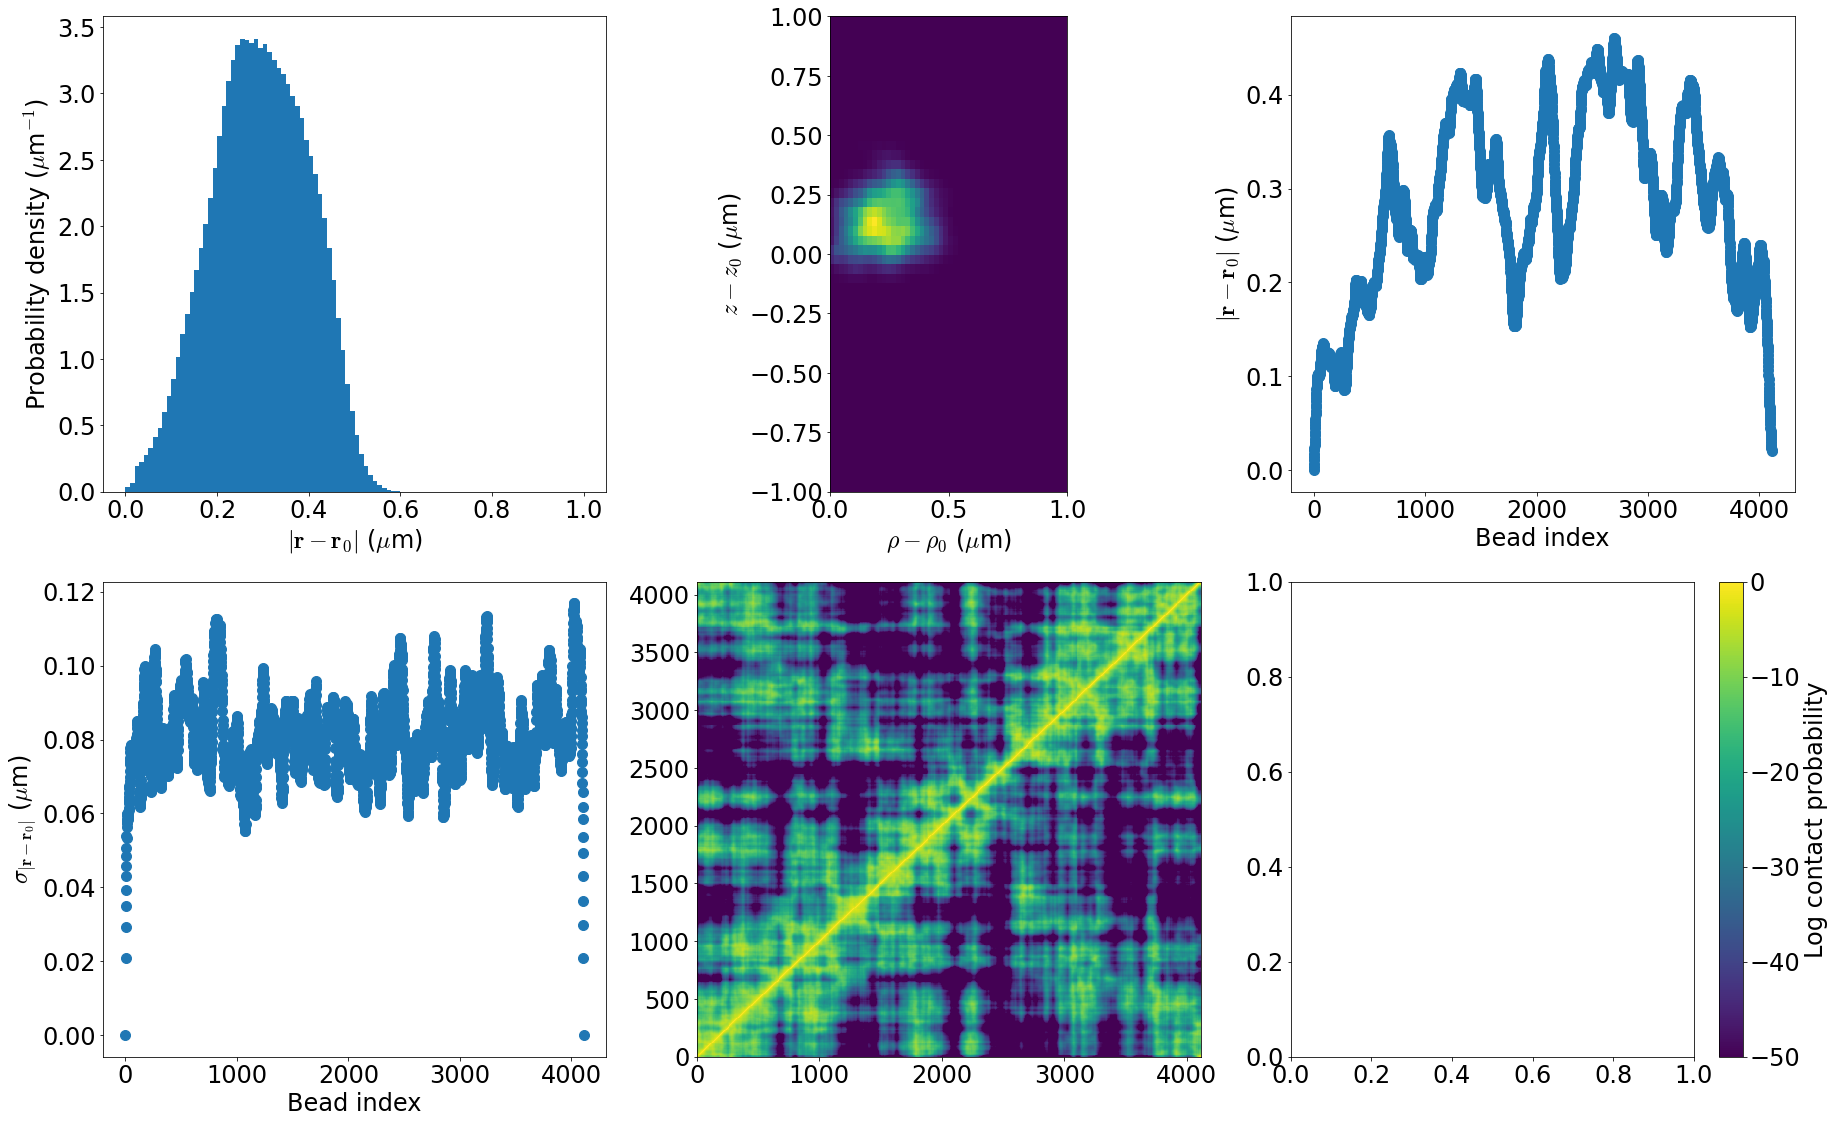

In [81]:
data_path = Path("21-04-06_AMchr1_RS_loop4112_pin_scan4.1_conf.6-5/simulations/Rconf0.6/")
with h5py.File(next(data_path.glob('*.h5')), 'r+') as h5_data:
    sy_dat = h5_data['raw_data']['sylinders'][...]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
    log_contact_avg_mat = get_time_avg_contact_mat(com_arr, avg_block_step = 8)
    fig, ax = make_total_distr_plots(com_arr, log_contact_avg_mat, hist_max=1.)

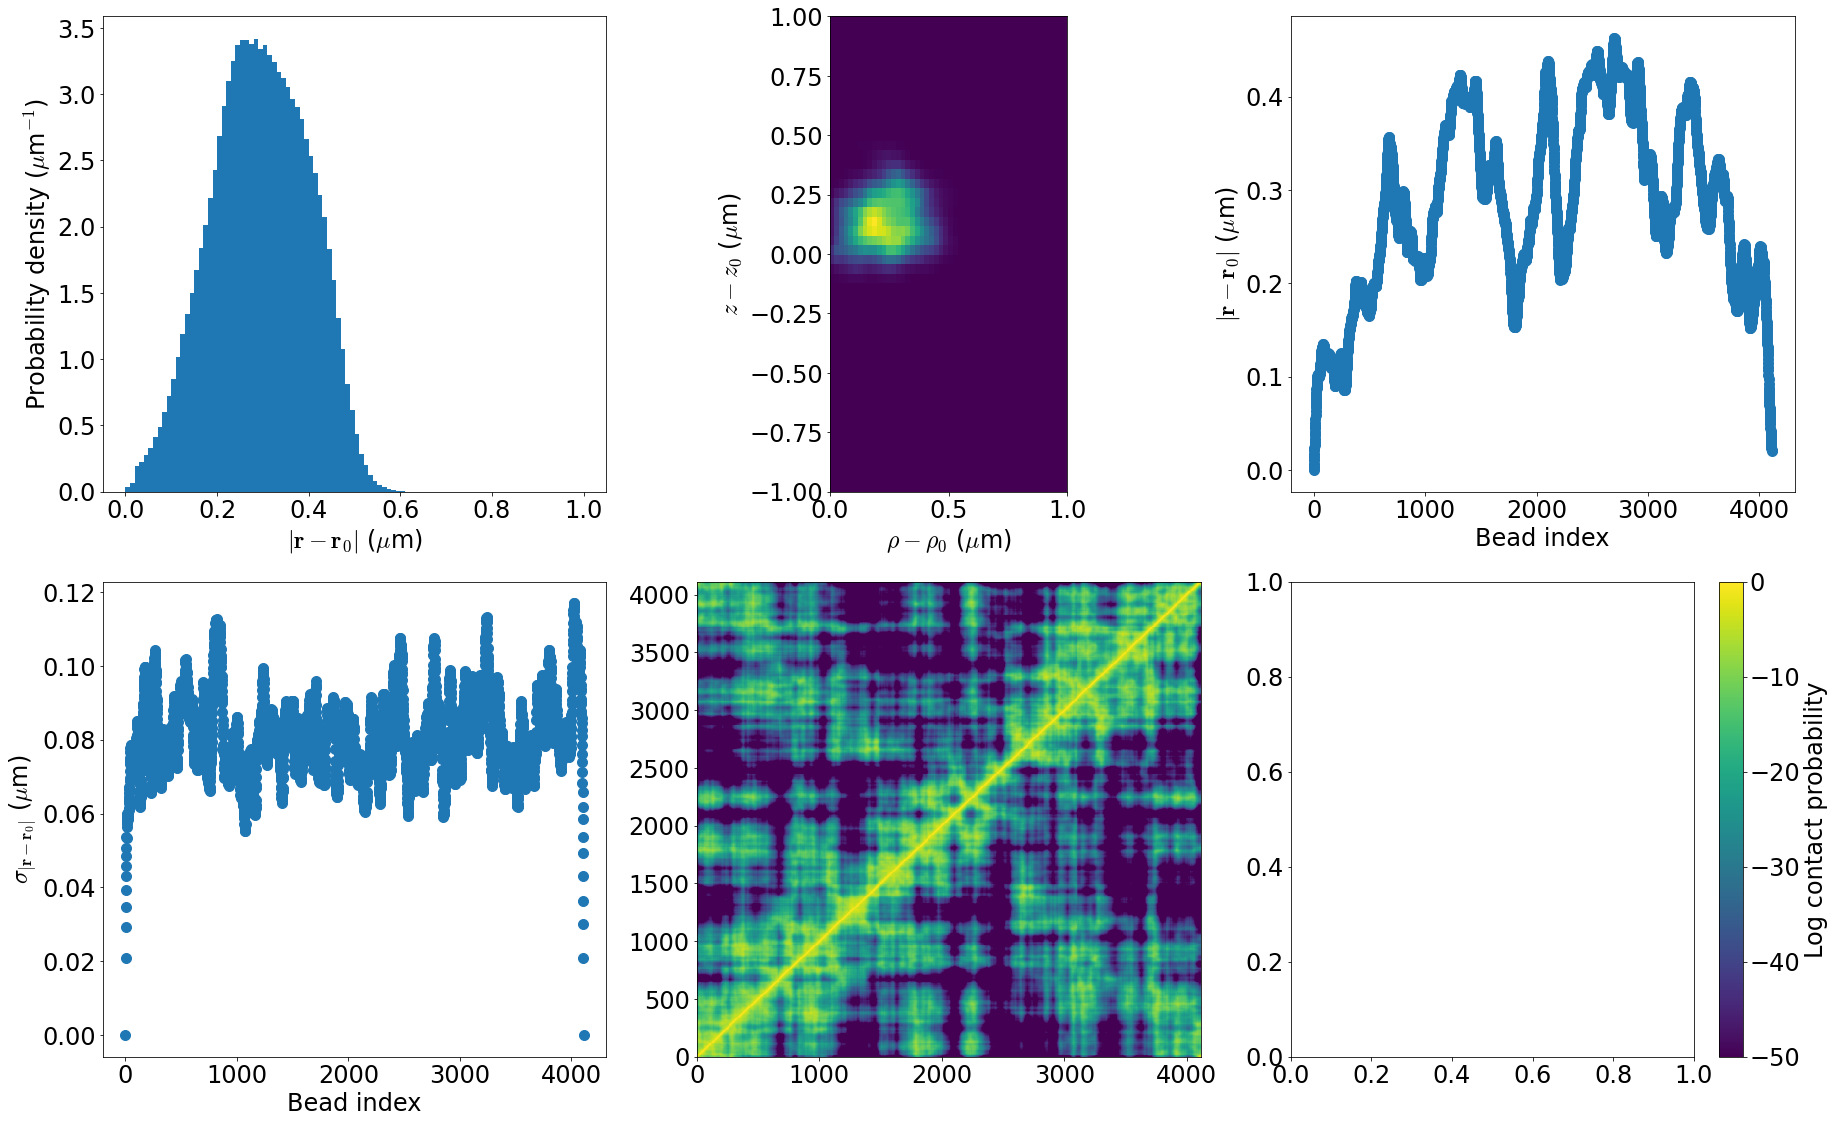

In [82]:
data_path = Path("21-04-06_AMchr1_RS_loop4112_pin_scan4.1_conf.6-5/simulations/Rconf1.25/")
with h5py.File(next(data_path.glob('*.h5')), 'r+') as h5_data:
    sy_dat = h5_data['raw_data']['sylinders'][...]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
    log_contact_avg_mat = get_time_avg_contact_mat(com_arr, avg_block_step = 8)
    fig, ax = make_total_distr_plots(com_arr, log_contact_avg_mat, hist_max=1.)

## SAW 520 confined loop scans

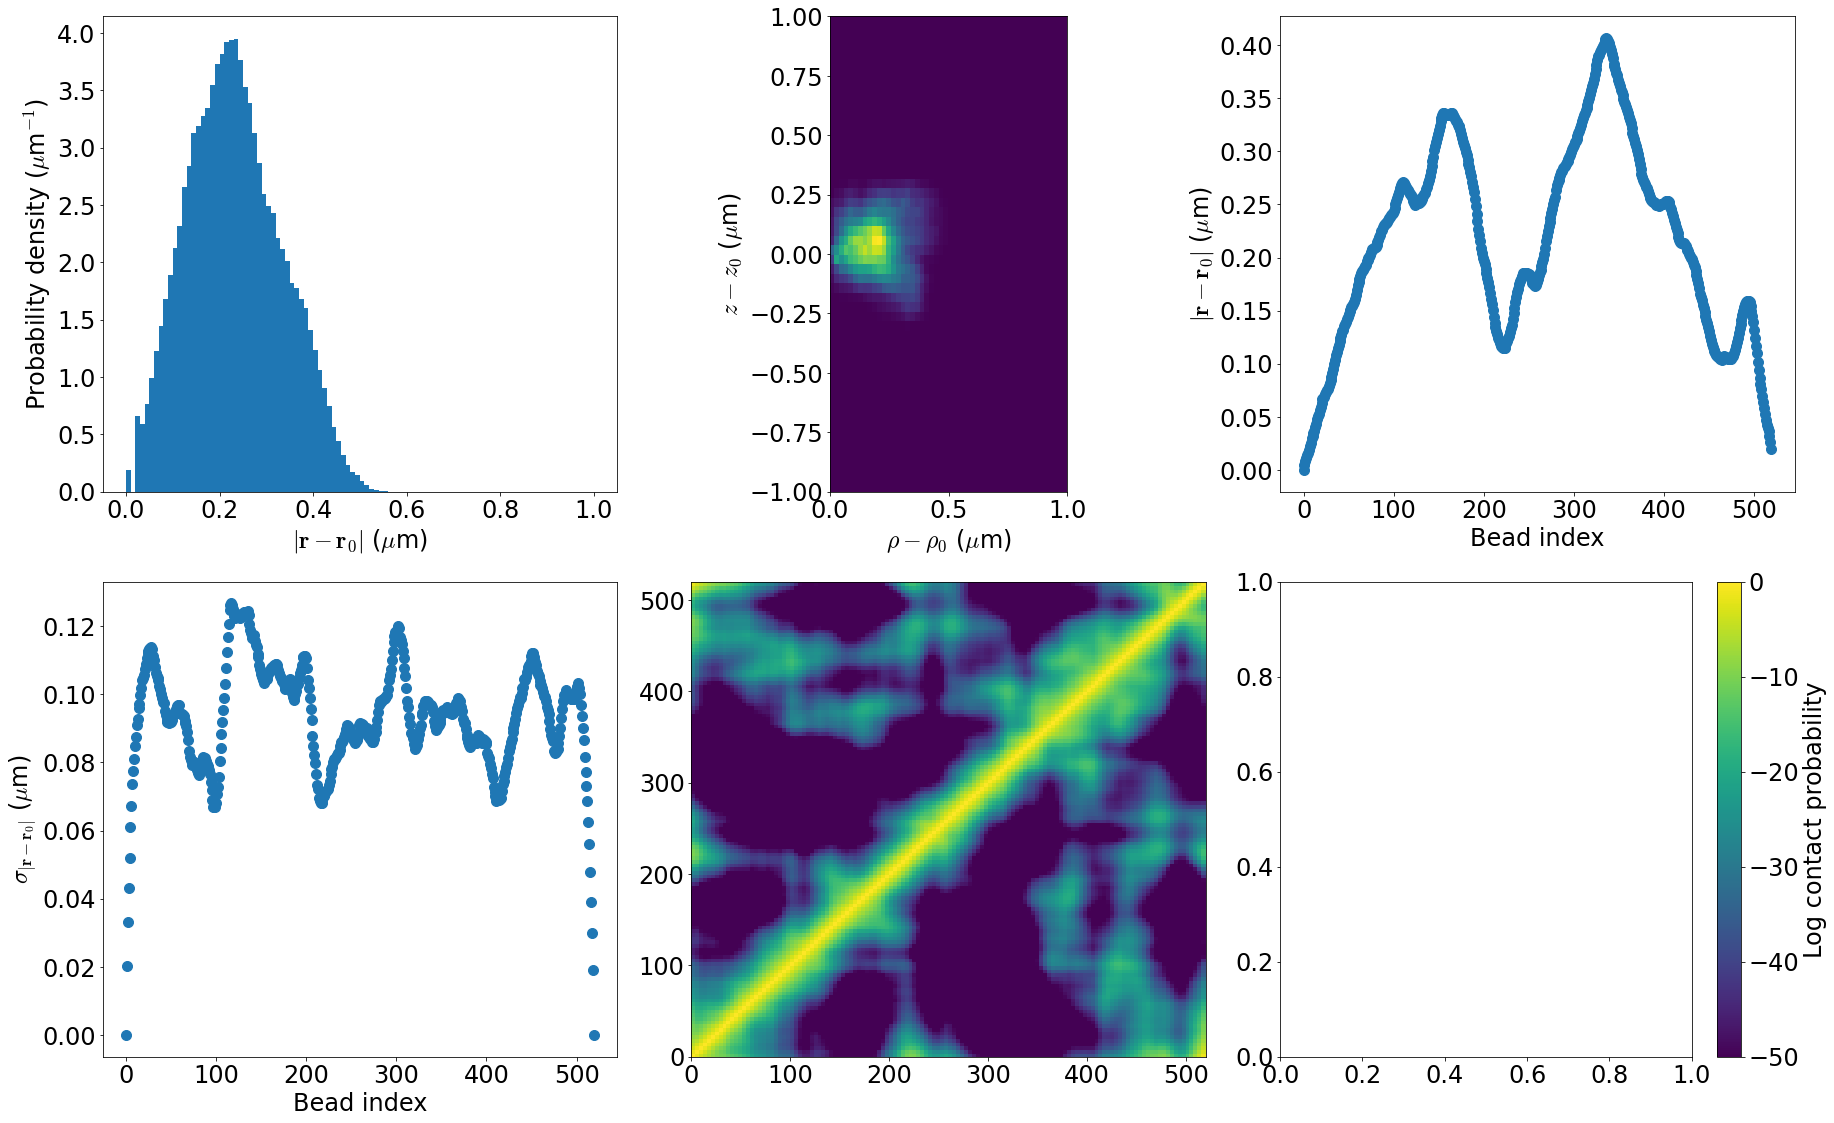

In [84]:
data_path = Path("21-04-06_AMchr1_loop520_pin_scan_conf.6-5/simulations/Rconf0.6/")
with h5py.File(next(data_path.glob('*.h5')), 'r+') as h5_data:
    sy_dat = h5_data['raw_data']['sylinders'][...]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
    log_contact_avg_mat = get_time_avg_contact_mat(com_arr, avg_block_step = 4)
    fig, ax = make_total_distr_plots(com_arr, log_contact_avg_mat, hist_max=1.)

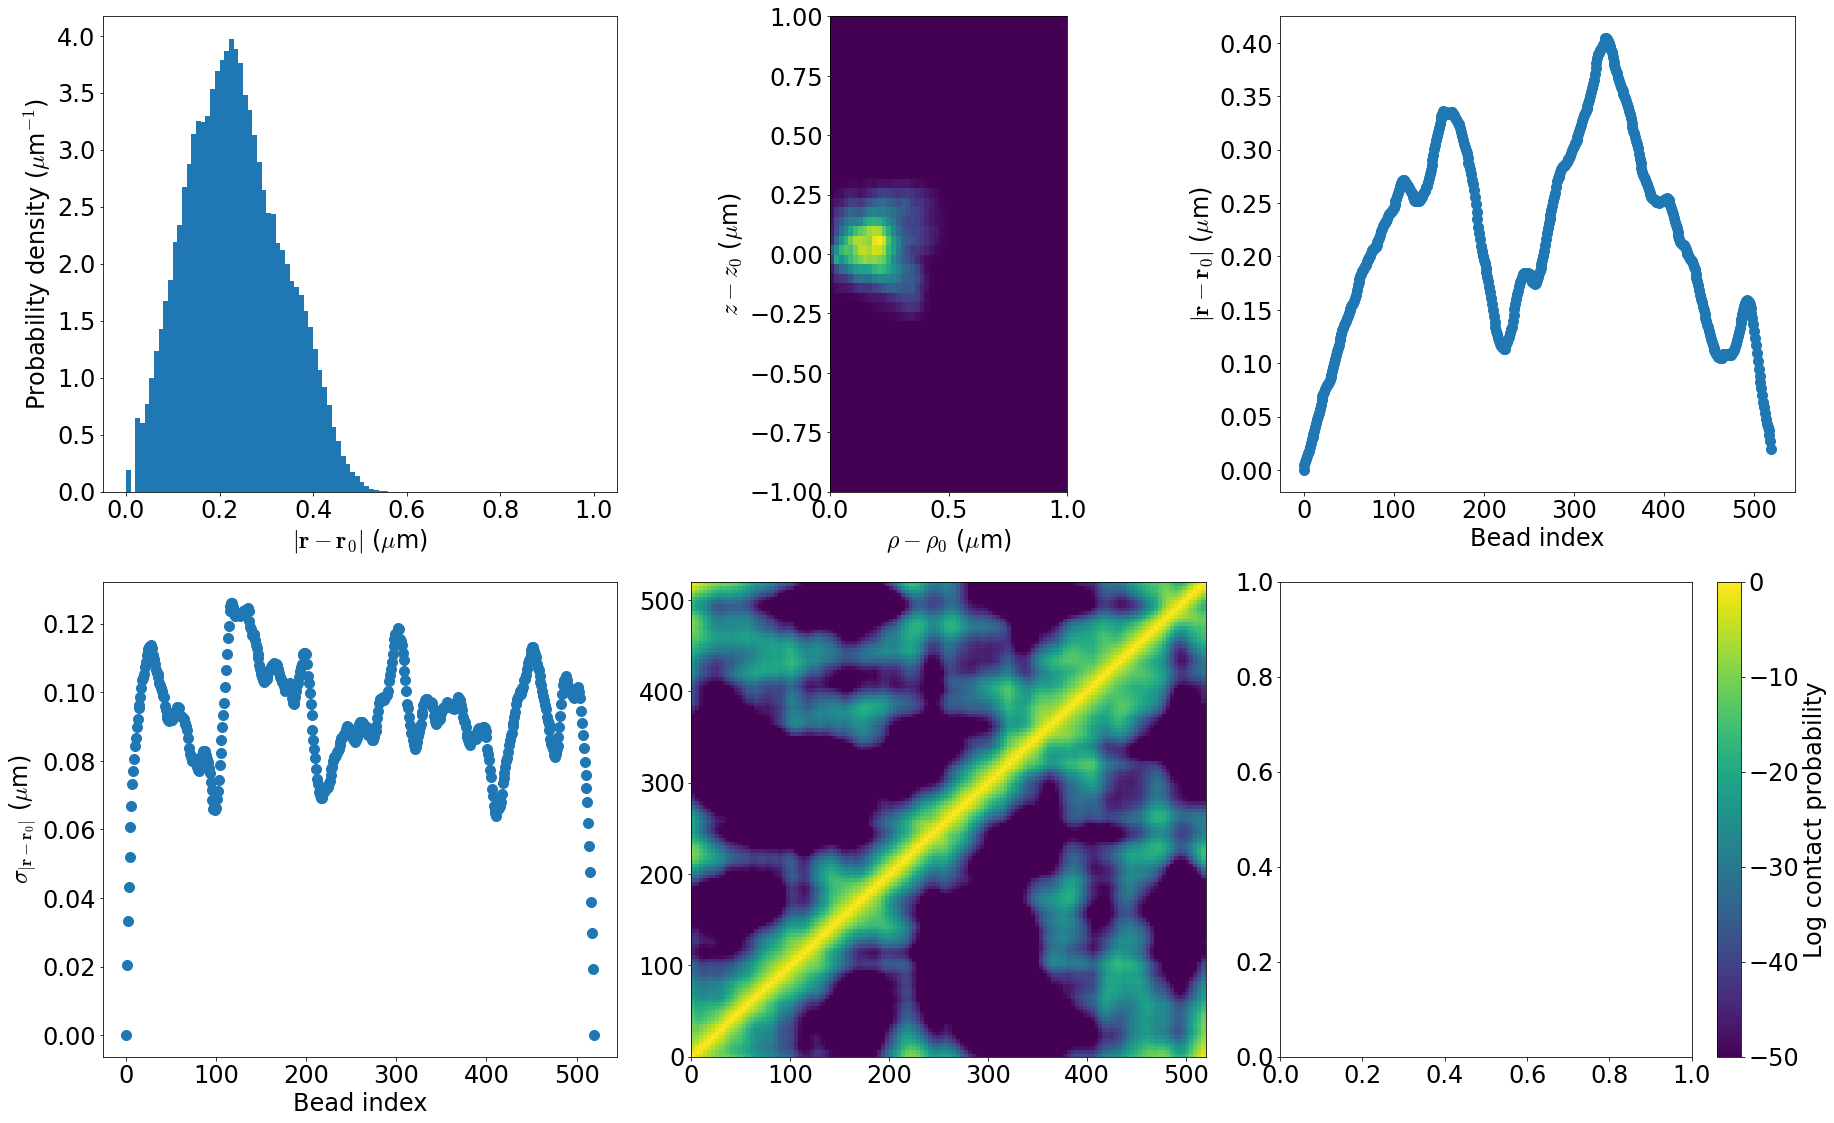

In [85]:
data_path = Path("21-04-06_AMchr1_loop520_pin_scan_conf.6-5/simulations/Rconf1.25/")
with h5py.File(next(data_path.glob('*.h5')), 'r+') as h5_data:
    sy_dat = h5_data['raw_data']['sylinders'][...]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
    log_contact_avg_mat = get_time_avg_contact_mat(com_arr, avg_block_step = 4)
    fig, ax = make_total_distr_plots(com_arr, log_contact_avg_mat, hist_max=1.)

[114 115 116 117 138 139]
[397 396 395 394 373 372]


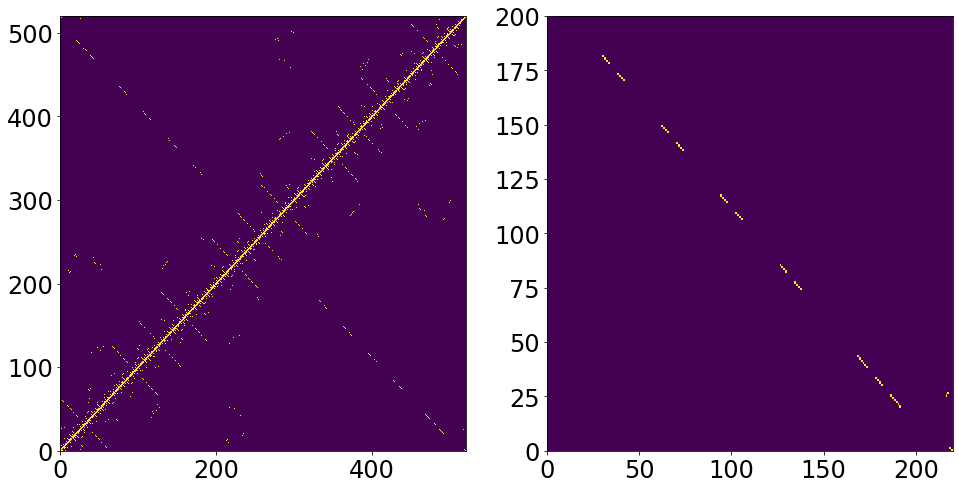

In [133]:
def find_neighbors(com_arr, diam, time_ind=0):
    """TODO: Docstring for find_neighbors.

    """
    neighbor_mat = (np.linalg.norm((com_arr[:, np.newaxis, :, time_ind] -
                                    com_arr[np.newaxis, :, :, time_ind]),
                                   axis=2) < diam * 1.2).astype(int)
    return neighbor_mat

data_path = Path("21-04-06_AMchr1_loop520_pin_scan_conf.6-5/simulations/Rconf0.6/")
with h5py.File(next(data_path.glob('*.h5')), 'r+') as h5_data:
    sy_dat = h5_data['raw_data']['sylinders'][...]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
    neighbor_mat = find_neighbors(com_arr, .02)
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))
    ax[0].pcolorfast(neighbor_mat)
    ax[1].pcolorfast(neighbor_mat[:200, 300:])
    x, y = np.where(neighbor_mat)
    x_ind = np.where((x > 110) & (x<140))
    print(x[x_ind][np.where(y[x_ind] > 520-150)])
    print(y[x_ind][np.where(y[x_ind] > 520-150)])
    #print(np.where(neighbor_mat))
    

## Rouse 520 confined loop scans

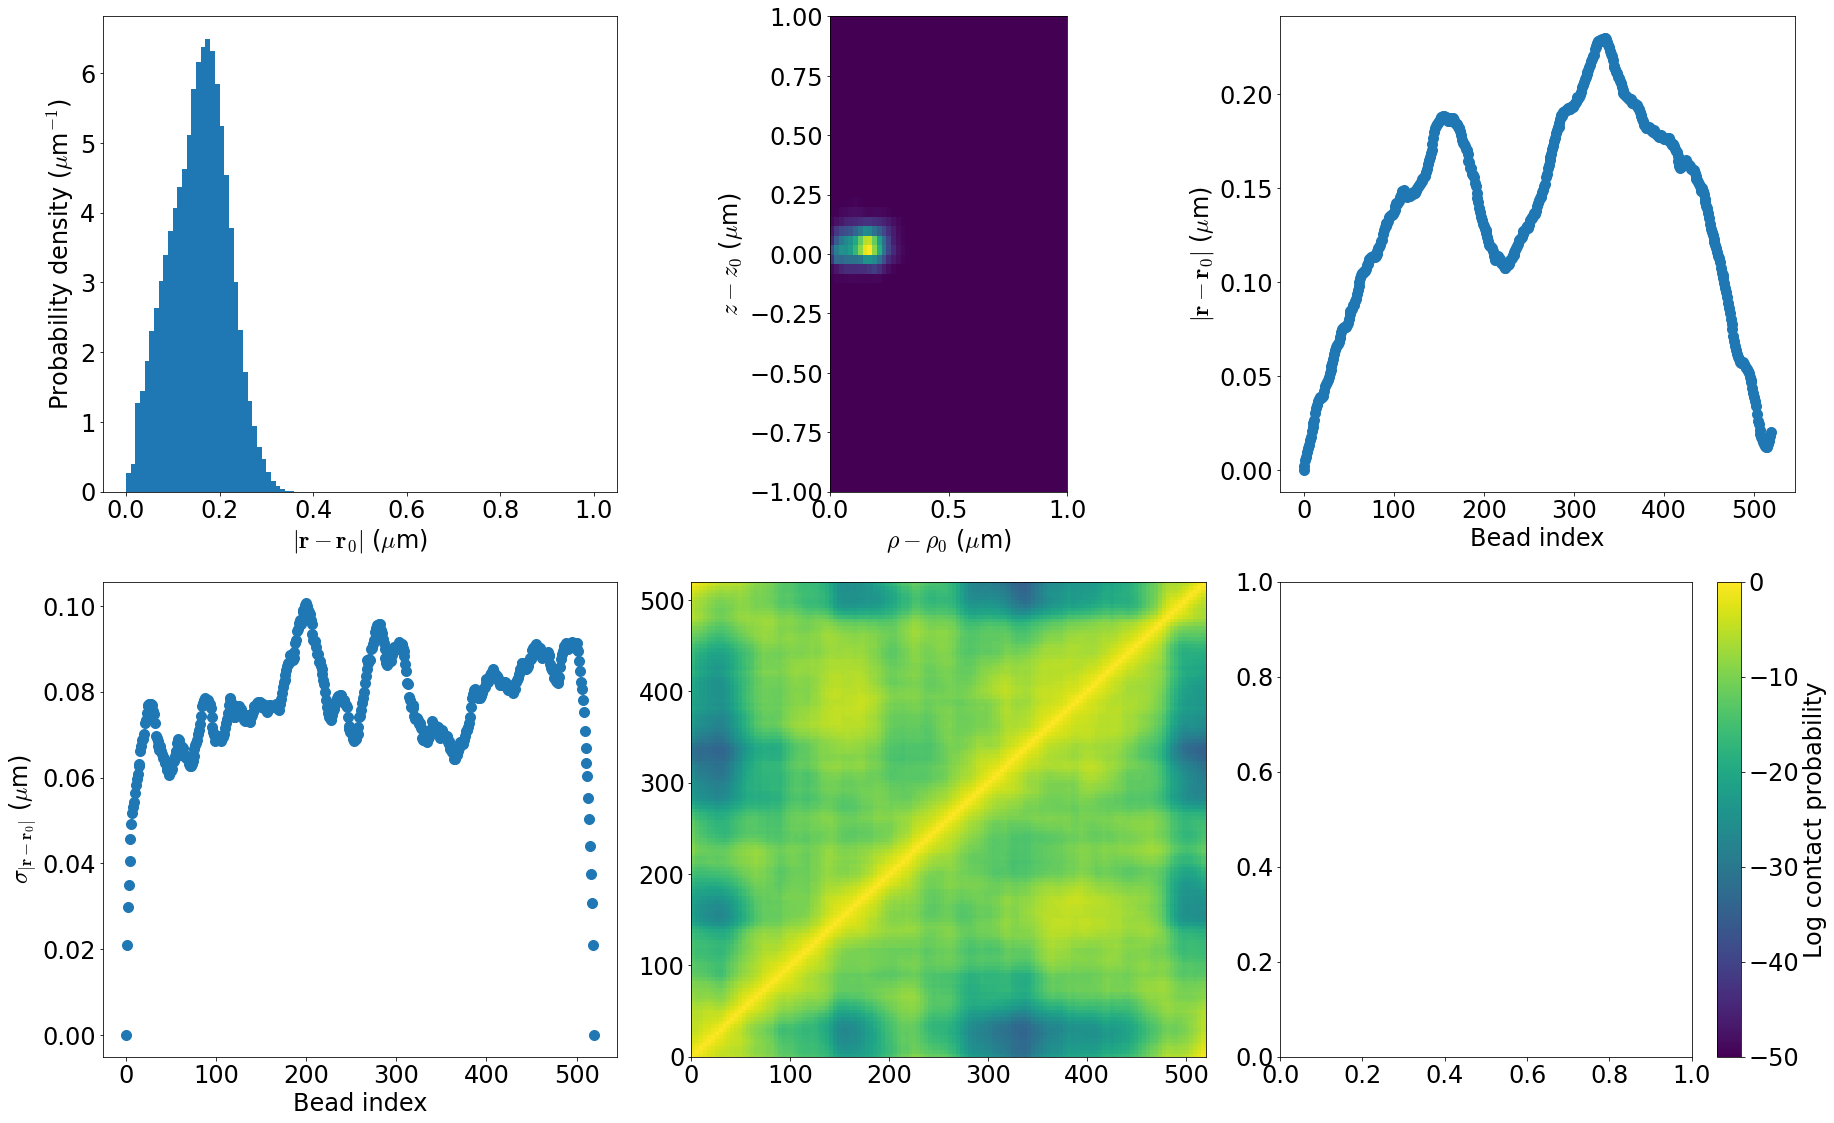

In [87]:
data_path = Path("21-04-06_AMchr1_RS_loop520_pin_scan4.1_conf.6-5/simulations/Rconf0.6/")
with h5py.File(next(data_path.glob('*.h5')), 'r+') as h5_data:
    sy_dat = h5_data['raw_data']['sylinders'][...]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
    log_contact_avg_mat = get_time_avg_contact_mat(com_arr, avg_block_step = 4)
    fig, ax = make_total_distr_plots(com_arr, log_contact_avg_mat, hist_max=1.)

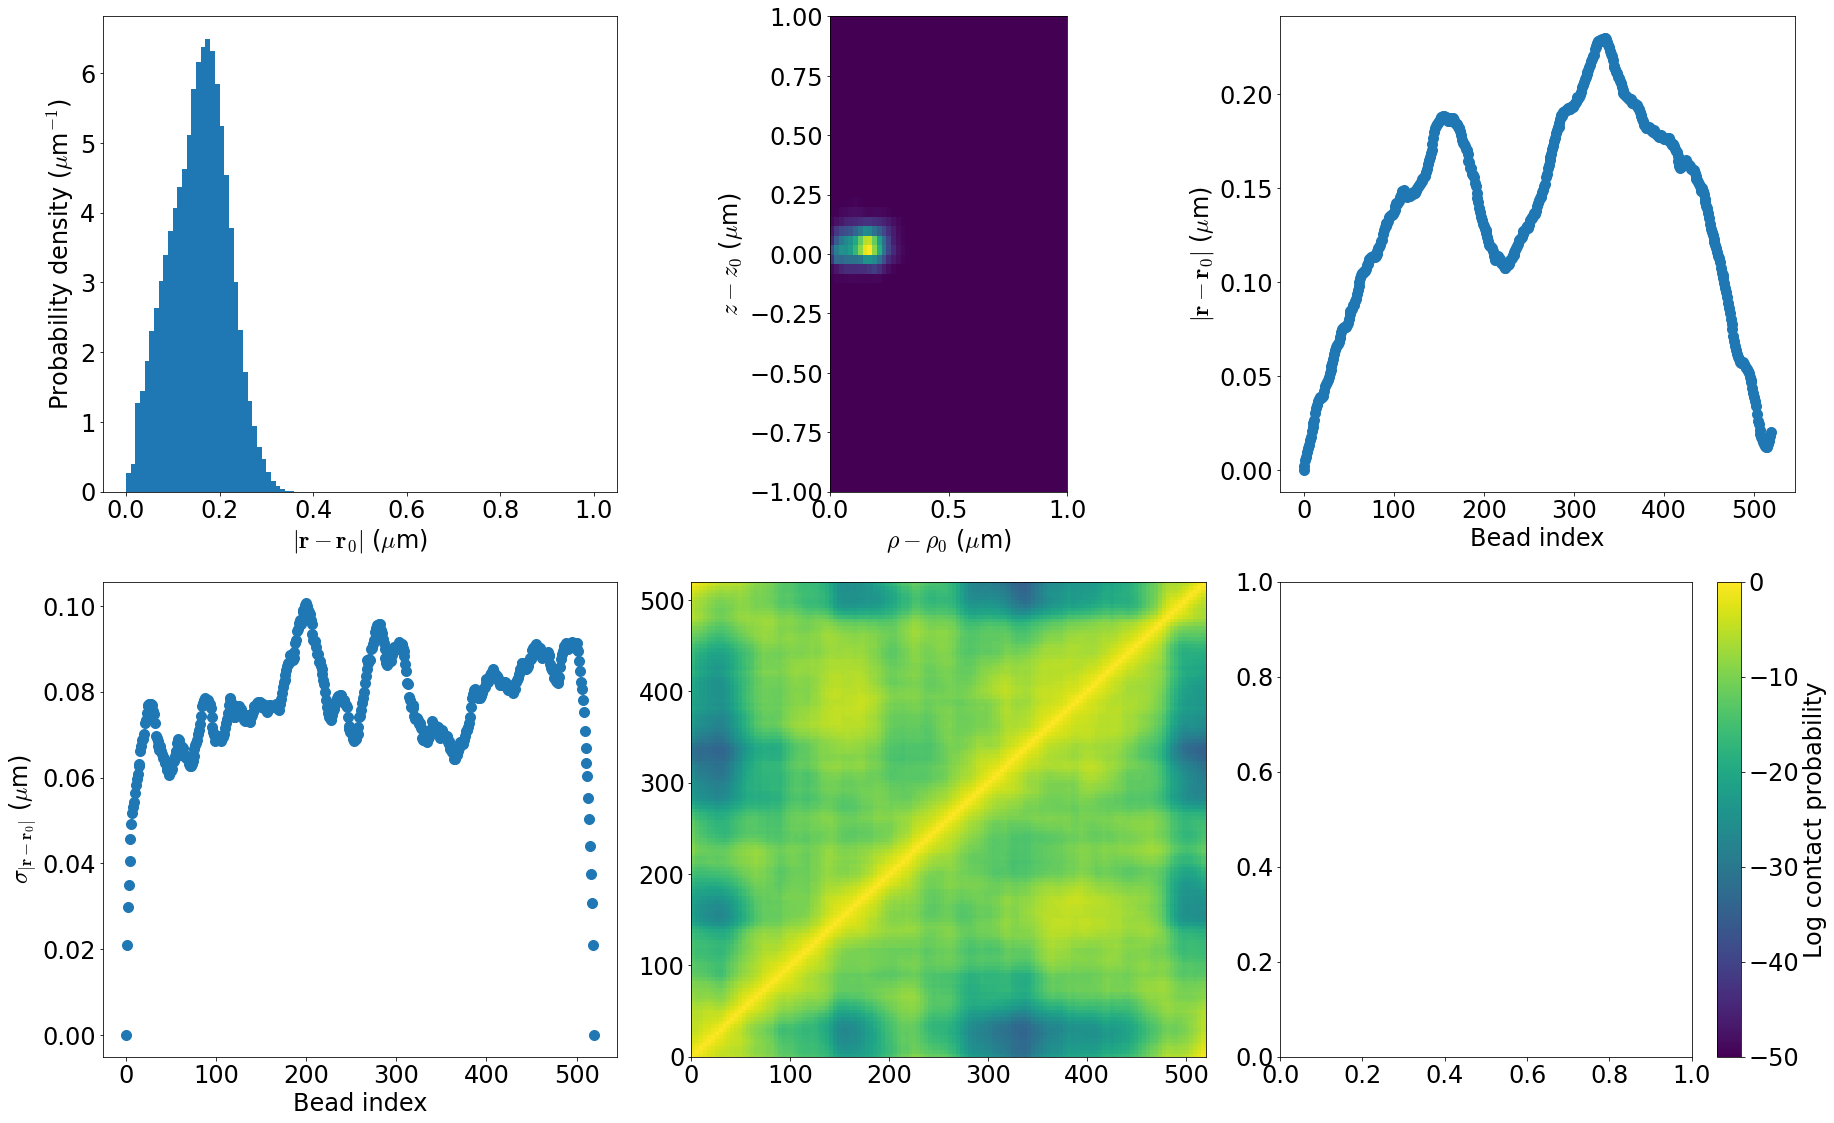

In [88]:
data_path = Path("21-04-06_AMchr1_RS_loop520_pin_scan4.1_conf.6-5/simulations/Rconf1.25/")
with h5py.File(next(data_path.glob('*.h5')), 'r+') as h5_data:
    sy_dat = h5_data['raw_data']['sylinders'][...]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
    log_contact_avg_mat = get_time_avg_contact_mat(com_arr, avg_block_step = 4)
    fig, ax = make_total_distr_plots(com_arr, log_contact_avg_mat, hist_max=1.)

# Conclusions and Next Steps